# Install Libraries

In [ ]:
!pip install ccxt -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow -qqq
!pip install keras -qqq

In [ ]:
try:
    import vectorbt as vbt
except ImportError:
    url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
    !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
    url = 'https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda'
    !curl -L $url -o /content/ta-lib.conda
    !mkdir /content/ta-lib
    !unzip /content/ta-lib.conda -d /content/ta-lib
    !sudo apt-get install zstd
    !tar --zstd -xvf /content/ta-lib/pkg-ta-lib-0.5.1-py311h9ecbd09_0.tar.zst lib/python3.11/site-packages/talib --strip-components=3
    !rm -rf /content/ta-lib.conda /content/ta-lib
    import talib
    !pip install -U vectorbt[full-no-talib]

    import os
    os.kill(os.getpid(), 9)

# Import Libraries

In [ ]:
import sys
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from numpy.linalg import norm
from scipy.stats import entropy
from sklearn.cluster import Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import ccxt
import logging
from pathlib import Path
from typing import List, Optional, Union

np.random.seed(0)

In [ ]:
import time
from datetime import datetime, timedelta

# Get the current timestamp in milliseconds
now_timestamp_ms = int(datetime.now().timestamp() * 1000)

# Convert milliseconds timestamp to seconds
timestamp_sec = now_timestamp_ms / 1000

# Convert timestamp to datetime object
datetime_object = datetime.now().fromtimestamp(timestamp_sec)

# Format the datetime object to 'year-month-dayTHour:Min:SecZ'
# '%Y' - Year with century
# '%m' - Month as a zero-padded decimal number
# '%d' - Day of the month as a zero-padded decimal number
# 'T'  - Literal 'T'
# '%H' - Hour (24-hour clock) as a zero-padded decimal number
# '%M' - Minute as a zero-padded decimal number
# '%S' - Second as a zero-padded decimal number
# 'Z'  - Literal 'Z' (often used to denote UTC time, though this code gets local time)
year_month_day_hour_min_sec_z = datetime_object.strftime('%Y-%m-%dT%H:%M:%SZ')

print(f"Formatted Datetime: {year_month_day_hour_min_sec_z}")

Formatted Datetime: 2025-06-21T15:15:04Z


# Load Data


From any ccxt supported exchange.

coinbase, gemini, kraken, binanceus, etc

Recommended => Coinbase.



## CCXT

In [ ]:
INSTRUMENT = "SOL/USDT"
TIMEFRAME = "4h" # 1h | 4h
EXCHANGE_ID = "binanceus"

In [ ]:
# Instantiate the exchange
exchange: ccxt.Exchange = getattr(ccxt, EXCHANGE_ID)()

# Load the markets to get exchange information, including timeframes
exchange.load_markets()

# Get and print the supported timeframes
exchange_timeframes = exchange.timeframes

if exchange_timeframes:
    print(f"Supported timeframes for {EXCHANGE_ID.capitalize()}:")
    for timeframe in exchange_timeframes:
        print(timeframe)
else:
    print(f"Could not retrieve timeframes for {EXCHANGE_ID.capitalize()}.")

Supported timeframes for Binanceus:
1s
1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M


In [ ]:
# Configure logger
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Add a log message to see output
logger.info("Logger configured successfully.")

def fetch_ohlcv_with_retries(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Fetch OHLCV data with retry logic."""
    for attempt in range(max_retries):
        try:
            return exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        except Exception as e:
            if attempt == max_retries - 1:
                logger.error(f"Failed to fetch {timeframe} {symbol} OHLCV after {max_retries} attempts: {e}")
                raise
    return []

def load_existing_data(filename: Path) -> pd.DataFrame:
    """Load existing OHLCV data if available."""
    if filename.exists():
        return pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")
    return pd.DataFrame(columns=["open", "high", "low", "close", "volume"])

def scrape_ohlcv(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, until: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Scrape historical OHLCV data from an exchange between two dates."""
    all_ohlcv: List[List[Union[int, float]]] = []

    while since < until:
        ohlcv: List[List[Union[int, float]]] = fetch_ohlcv_with_retries(exchange, symbol, timeframe, since, limit, max_retries)

        if not ohlcv:
            break

        since = ohlcv[-1][0] + 1  # Move forward in time
        all_ohlcv.extend(ohlcv)
        logger.info(f"{len(all_ohlcv)} {symbol} candles collected from {exchange.iso8601(all_ohlcv[0][0])} to {exchange.iso8601(all_ohlcv[-1][0])}")

    return all_ohlcv

def save_to_csv(filename: Path, data: pd.DataFrame) -> None:
    """Save OHLCV data to a CSV file, appending new data if necessary."""
    if filename.exists():
        data.to_csv(filename, mode='a', header=False)
    else:
        data.to_csv(filename)
    logger.info(f"Data saved to {filename}")

def scrape_and_save_candles(exchange_id: str, symbol: str, timeframe: str, since: Union[int, str], until: Union[int, str], limit: int, max_retries: int = 3, filename: Optional[str] = None, exchange_options: Optional[dict] = None) -> None:
    """Scrape OHLCV data and save to a CSV file, supporting resuming downloads."""

    if filename is None or len(filename) == 0:
        filename = f"{symbol.replace('/', '_')}_{timeframe}.csv".lower()

    exchange_options = exchange_options or {}
    exchange: ccxt.Exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True, 'options': exchange_options})

    if isinstance(since, str):
        since = exchange.parse8601(since)
    if not until:
        until = exchange.milliseconds()
    elif isinstance(until, str):
        until = exchange.parse8601(until)

    exchange.load_markets()
    file_path = Path("./data/ccxt/") / exchange_id / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)
    existing_data = load_existing_data(file_path)

    if not existing_data.empty:
        last_timestamp = existing_data.index[-1].timestamp() * 1000  # Convert to ms
        if last_timestamp > since:
            since = int(last_timestamp) + 1  # Resume from the next candle

    ohlcv = scrape_ohlcv(exchange, symbol, timeframe, since, until, limit, max_retries)

    if ohlcv:
        new_data = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
        new_data["timestamp"] = pd.to_datetime(new_data["timestamp"], unit='ms')
        if not new_data.empty:
            if not existing_data.empty:
                existing_data.reset_index(inplace=True)
                combined_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            else:
                combined_data = new_data.drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            save_to_csv(file_path, combined_data)
            logger.info(f"Saved {len(new_data)} new candles from {new_data.iloc[0, 0]} to {new_data.iloc[-1, 0]} to {filename}")
        else:
            logger.warning("No new OHLCV data to save.")
    else:
        logger.warning("No new OHLCV data retrieved.")


In [ ]:
EXCHANGE_ID, INSTRUMENT, TIMEFRAME

('binanceus', 'SOL/USDT', '4h')

In [ ]:
def get_ccxt_data(exchange_id, symbol, timeframe, start_date="2019-06-01T00:00:00Z", end_date="2025-06-19T23:59:59Z"):
    """
    Loads historical data for a given symbol from a CSV file,
    or scrapes it if not found. Cleans and validates the data.
    """
    filepath = Path(f"./data/ccxt/{exchange_id}/{symbol.replace('/', '_')}_{timeframe}.csv".lower())

    try:
        # Load the data from the individual CSV file
        data = pd.read_csv(filepath, parse_dates=["timestamp"])
        if "Unnamed: 0" in data.columns:
            data.drop(columns=["Unnamed: 0"], inplace=True)
        return data
    except FileNotFoundError:
        print(f"Data file for {symbol} not found at {filepath}. Scraping data...")
        scrape_and_save_candles(
            exchange_id=exchange_id,
            symbol=symbol,
            timeframe=timeframe,
            since=start_date,
            until=end_date,
            limit=1000
        )
        # Try loading again after scraping
        try:
            data = pd.read_csv(filepath, parse_dates=["timestamp"])
            if "Unnamed: 0" in data.columns:
                data.drop(columns=["Unnamed: 0"], inplace=True)
            return data
        except Exception as e:
            print(f"Error loading scraped data for {symbol} from {filepath}: {e}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error loading or parsing data for {symbol} from {filepath}: {e}")
        return pd.DataFrame()


# "2025-06-20T23:59:59Z"
ohlcv = get_ccxt_data(exchange_id=EXCHANGE_ID, symbol=INSTRUMENT, timeframe=TIMEFRAME, start_date="2019-06-01T00:00:00Z", end_date=year_month_day_hour_min_sec_z)
ohlcv

Data file for SOL/USDT not found at data/ccxt/binanceus/sol_usdt_4h.csv. Scraping data...


,timestamp,open,high,low,close,volume
0,2020-09-18 12:00:00,3.0887,3.1355,2.8178,2.8929,5938.630
1,2020-09-18 16:00:00,2.9105,3.1543,2.8191,3.1487,9460.390
2,2020-09-18 20:00:00,3.1429,3.1490,3.0340,3.0994,1170.880
3,2020-09-19 00:00:00,3.0960,3.2430,3.0946,3.1240,3186.390
4,2020-09-19 04:00:00,3.1298,3.1453,3.0708,3.1044,327.100
...,...,...,...,...,...,...
10416,2025-06-20 20:00:00,139.9500,141.8800,138.7900,140.1900,1064.084
10417,2025-06-21 00:00:00,140.1000,141.3000,139.6200,140.8800,541.655
10418,2025-06-21 04:00:00,140.6900,140.6900,139.8400,140.2500,24.002
10419,2025-06-21 08:00:00,140.3800,142.4900,140.3800,142.4900,38.985


## Yahoo Finance


No enough data for the following:
- 'PI35697-USD'


**Indices for Alpha Generation:**
- USD Dollar Index (DXY/USDX/DX-Y.NYB)
- Trade-Weighted Dollar Index (DTWEXBGS)

*Why they matter for alpha generation:*
- They are proxies of **USD strength**, impacting global liquidity, capital flows, and inflation expectations.
- many risk assets, commodities, emerging markets, and cryptocurrencies are inversely correlated withthe dollar.
- Useful for both directional strategies and regime-based filters.




In [ ]:
# # Fetch AAPL data
# advpp_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# # Display the first few rows of the dataframe
# advpp_data.head()

# --- Step 1: Fetch BTC/USD 15-min data for the last 7 days ---
# ticker="BTC-USD"
# interval="15m"
# ticker_data = yf.download(ticker, interval=interval, period="7d")
# ticker_data.dropna(inplace=True)
# ticker_data.columns = [col.lower() for col in ticker_data.columns]
# ticker_data

# ---- Parameters ----
indices = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 'DX-Y.NYB']
stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA', 'INTC', 'QUBT', 'COIN', 'META']
fx = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'EURGBP=X', 'EURNZD=X', 'EURCHF=X', 'GBPNZD=X', 'GBPCHF=X']
metals = ['^XAU', '^XAG']
commodities = ['CL=F']
crypto = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD', 'LTC-USD', 'AAVE-USD', 'BNB-USD', 'TRX-USD', 'DOT-USD', 'XLM-USD']
symbols = indices + stocks + fx + metals + commodities + crypto
start_date = '2018-06-01'
end_date = '2025-06-19'
interval = '1d'

# Create a directory to store data if it doesn't exist
data_dir = './data/yahoo'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Fetch and save data for each symbol individually
for symbol in symbols:
    try:
        print(f"Fetching data for {symbol}...")
        df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
        if not df.empty:
            df.columns = df.columns.droplevel(1)
            filename = os.path.join(data_dir, f'{symbol.replace("-", "_").replace("=", "")}.csv')
            df.to_csv(filename)
            print(f"Saved data for {symbol} to {filename}")
        else:
            print(f"No data found for {symbol}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")


Fetching data for ^GSPC...


/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^GSPC to ./data/yahoo/^GSPC.csv
Fetching data for ^DJI...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^DJI to ./data/yahoo/^DJI.csv
Fetching data for ^IXIC...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^IXIC to ./data/yahoo/^IXIC.csv
Fetching data for ^RUT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^RUT to ./data/yahoo/^RUT.csv
Fetching data for ^VIX...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^VIX to ./data/yahoo/^VIX.csv
Fetching data for DX-Y.NYB...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for DX-Y.NYB to ./data/yahoo/DX_Y.NYB.csv
Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AAPL to ./data/yahoo/AAPL.csv
Fetching data for AMZN...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AMZN to ./data/yahoo/AMZN.csv
Fetching data for MSFT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for MSFT to ./data/yahoo/MSFT.csv
Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for NVDA to ./data/yahoo/NVDA.csv
Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for TSLA to ./data/yahoo/TSLA.csv
Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for INTC to ./data/yahoo/INTC.csv
Fetching data for QUBT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for QUBT to ./data/yahoo/QUBT.csv
Fetching data for COIN...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for COIN to ./data/yahoo/COIN.csv
Fetching data for META...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for META to ./data/yahoo/META.csv
Fetching data for EURUSD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURUSD=X to ./data/yahoo/EURUSDX.csv
Fetching data for GBPUSD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPUSD=X to ./data/yahoo/GBPUSDX.csv
Fetching data for USDJPY=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for USDJPY=X to ./data/yahoo/USDJPYX.csv
Fetching data for USDCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for USDCHF=X to ./data/yahoo/USDCHFX.csv
Fetching data for EURGBP=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

Saved data for EURGBP=X to ./data/yahoo/EURGBPX.csv
Fetching data for EURNZD=X...



/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURNZD=X to ./data/yahoo/EURNZDX.csv
Fetching data for EURCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURCHF=X to ./data/yahoo/EURCHFX.csv
Fetching data for GBPNZD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPNZD=X to ./data/yahoo/GBPNZDX.csv
Fetching data for GBPCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPCHF=X to ./data/yahoo/GBPCHFX.csv
Fetching data for ^XAU...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^XAG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-06-01 -> 2025-06-19)')


Saved data for ^XAU to ./data/yahoo/^XAU.csv
Fetching data for ^XAG...
No data found for ^XAG
Fetching data for CL=F...


/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for CL=F to ./data/yahoo/CLF.csv
Fetching data for BTC-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for BTC-USD to ./data/yahoo/BTC_USD.csv
Fetching data for ETH-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ETH-USD to ./data/yahoo/ETH_USD.csv
Fetching data for SOL-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for SOL-USD to ./data/yahoo/SOL_USD.csv
Fetching data for XRP-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for XRP-USD to ./data/yahoo/XRP_USD.csv
Fetching data for LTC-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for LTC-USD to ./data/yahoo/LTC_USD.csv
Fetching data for AAVE-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AAVE-USD to ./data/yahoo/AAVE_USD.csv
Fetching data for BNB-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for BNB-USD to ./data/yahoo/BNB_USD.csv
Fetching data for TRX-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for TRX-USD to ./data/yahoo/TRX_USD.csv
Fetching data for DOT-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-1142304459.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for DOT-USD to ./data/yahoo/DOT_USD.csv
Fetching data for XLM-USD...


[*********************100%***********************]  1 of 1 completed

Saved data for XLM-USD to ./data/yahoo/XLM_USD.csv


In [ ]:
def get_yahoo_data(symbol):
    """
    Loads historical data for a given symbol from a CSV file,
    cleans and validates it.
    If the file is not found, it attempts to download and save the data.
    """
    # Replace characters that might cause issues in filenames
    filename_symbol = symbol.replace("-", "_").replace("=", "")
    filepath = os.path.join(data_dir, f'{filename_symbol}.csv')

    try:
        # Load the data from the individual CSV file
        df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
        print(f"\nLoaded data for {symbol} from {filepath}")
    except FileNotFoundError:
        print(f"Data file for {symbol} not found at {filepath}. Attempting to download...")
        try:
            # Attempt to download the data
            df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
            if not df.empty:
                # Ensure columns are consistent (remove MultiIndex if present)
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.droplevel(1)

                # Create the directory if it doesn't exist before saving
                os.makedirs(data_dir, exist_ok=True)

                df.to_csv(filepath)
                print(f"Downloaded and saved data for {symbol} to {filepath}")
                # Reload the data from the saved CSV to ensure consistency
                df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
            else:
                print(f"No data found for {symbol} during download attempt.")
                return pd.DataFrame()  # Return empty DataFrame if no data downloaded
        except Exception as download_error:
            print(f"Error downloading data for {symbol}: {download_error}")
            return pd.DataFrame()  # Return empty DataFrame if download fails
    except Exception as e:
        print(f"Error loading or parsing data for {symbol} from {filepath}: {e}")
        return pd.DataFrame() # Return empty DataFrame on other errors

    # Convert column names to lowercase
    df.columns = df.columns.str.lower()

    # Convert relevant columns to numeric, coercing errors
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            # Print a warning if a critical column is missing, but don't fail immediately
            if col in ['close', 'high', 'low']:
                 print(f"Warning: Critical column '{col}' not found in data for {symbol}. This might affect data quality.")


    # Optional: Drop rows where all critical values are NaN
    # Ensure the columns exist before trying to drop based on them
    critical_cols = [col for col in ['close', 'high', 'low'] if col in df.columns]
    if critical_cols:
        df.dropna(subset=critical_cols, how='all', inplace=True)
    else:
         # If critical columns are missing and couldn't be coerced, the dataframe is likely not useful
         print(f"Warning: Critical columns (close, high, low) missing or not numeric for {symbol} after cleaning. Returning empty DataFrame.")
         return pd.DataFrame()


    # Require a minimum number of data points after cleaning
    if df.empty or len(df) < 10:
        print(f"Warning: Not enough valid data points (less than 10) for symbol {symbol} after cleaning. Found {len(df)} rows.")
        return pd.DataFrame()

    return df

## Extract Price Series


## ✅ **Proposal**

We want to construct a custom price like:

$$
\text{Price}_{\text{custom}} = w_1 \cdot \text{High}_t + w_2 \cdot \text{Low}_t + w_3 \cdot \text{Close}_t
$$

Where:

* $w_1, w_2, w_3$ are weights, possibly adaptive or fixed.
* This synthetic series is then used as the "price" input into your features, indicators, or models.

---

## 🔍 Why This Can Be Powerful

Most indicators use **close-only**, which discards valuable intraday range information. A weighted blend:

* Captures **intrabar structure**.
* Smooths volatility.
* Can encode **market sentiment** better than raw closes.

---

## 📐 Common Weighted Price Schemes

Here are some **existing techniques** that can inspire or be combined with your idea:

### 1. **Typical Price**

$$
\text{TP} = \frac{High + Low + Close}{3}
$$

### 2. **Weighted Close**

$$
\text{WC} = \frac{High + Low + 2 \cdot Close}{4}
$$

### 3. **OHLC Average**

$$
\text{OHLC} = \frac{Open + High + Low + Close}{4}
$$

### 4. **Mid Price**

$$
\text{Mid} = \frac{High + Low}{2}
$$

### 5. **Custom Weights (Your Idea)**

$$
\text{P}_{\text{custom}} = \alpha \cdot H + \beta \cdot L + \gamma \cdot C \quad \text{where} \quad \alpha + \beta + \gamma = 1
$$

You can learn these weights in a model, optimize for Sharpe, or define them heuristically.

---

## 💡 How to Choose the Weights

### 1. **Heuristic**

Try:

* $\alpha = 0.25, \beta = 0.25, \gamma = 0.5$
* $\gamma = 1.0$ (use close-only as baseline)
* Use volatility to scale H/L contributions.

### 2. **Machine Learning / Optimization**

* Use **Sharpe-ratio maximization** to learn optimal weights.
* Or use a **regression model** to predict next return and fit the weights that best predict it.

### 3. **Reinforcement Learning Integration**

* Let your RL agent learn the weights $\alpha, \beta, \gamma$ as parameters over time.
* Plug into observation: `obs = price_custom`, where `price_custom = weighted(H, L, C)`.

---

## 🧪 Implementation Snippet (Python)

```python
def custom_price(high, low, close, alpha=0.3, beta=0.3, gamma=0.4):
    return alpha * high + beta * low + gamma * close
```

Or, to optimize weights dynamically:

```python
def adaptive_price(high, low, close, vol):
    alpha = 0.3 + 0.2 * vol
    beta = 0.3 - 0.1 * vol
    gamma = 1 - alpha - beta
    return alpha * high + beta * low + gamma * close
```

---

## 🧠 Strategic Use in a Trading Pipeline

* Use as the **main input price** to:

  * Indicators (RSI, MACD, Bollinger)
  * Pattern detectors (reversals, breakouts)
  * RL environments (in `price_matrix`)
* Apply it to **volume-weighted** or **volatility-adjusted** views
* Use difference or change in this price to detect **price aggression** or **liquidity pressure**



In [ ]:
# === STEP 1: Get price series ===
# dates = pd.date_range(start="2021-01-01", periods=15, freq="M")
# prices = np.array([
#     30000, 33000, 29000, 35000, 34000,
#     38000, 36000, 42000, 40000, 48000,
#     47000, 52000, 50000, 58000, 62000
# ], dtype=float)
# Extract price series
dates = ohlcv["timestamp"].values
highs = ohlcv["high"].values
lows = ohlcv["low"].values
closes = ohlcv["close"].values
volumes = ohlcv["volume"].values

prices = closes

# Pivots - Price Rejection Points



Pivots => Support/Resistance


## Bin-Based Algorithm for Pivots

**BinPivots**


```pine
indicator("BIN Based Support and Resistance [SS]", overlay=true)
lookback = input.int(500, "Lookback Length")
displaylabel = input.string("On SR lines", "Where would you like the statistics to display?", ["On SR lines", "Table", "OFF"])
offset = input.int(100, "Offset the lines ahead")
```


[Link](https://www.tradingview.com/script/AtzwB4pU-BIN-Based-Support-and-Resistance-SS/#:~:text=Bin%20Based%20Support%20and%20Resistance%20Levels%20dynamically%20adjust%20to%20ranges,at%20random%20peaks%20and%20valleys.&text=You%20can%20see%20these%202%20SR%20lines%20are%20close%20together.)


In [ ]:
ohlcv.shape

(10421, 6)

In [ ]:

def bin_based_support_resistance(df: pd.DataFrame, lookback: int = 500):
    # Ensure enough data
    if len(df) < lookback:
        raise ValueError("Not enough data for the given lookback period.")

    # Slice recent lookback window
    df_lb = df.tail(lookback).copy()

    max_close = df_lb['close'].max()
    min_close = df_lb['close'].min()
    bin_size = (max_close - min_close) / 10

    # Bin thresholds
    lbin = [min_close + i * bin_size for i in range(1, 6)]
    ubin = [max_close - i * bin_size for i in reversed(range(1, 6))]

    # Bin membership logic
    def assign_bin(value):
        thresholds = lbin + ubin
        for i in range(10):
            lower = min_close + i * bin_size
            upper = lower + bin_size if i < 9 else float('inf')
            if lower <= value < upper:
                return i + 1
        return None

    df_lb['bin'] = df_lb['close'].apply(assign_bin)

    # Collect values per bin
    bin_closes = {i: [] for i in range(1, 11)}
    for i in range(lookback):
        b = df_lb['bin'].iloc[i]
        if b is not None:
            bin_closes[b].append(df_lb['close'].iloc[i])

    # Compute average SR levels
    sr_levels = {f'sr{i}': np.mean(bin_closes[i]) if bin_closes[i] else np.nan for i in range(1, 11)}

    # Rejection statistic calculation
    def calculate_statistics(level, df_slice):
        if np.isnan(level):
            return np.nan, np.nan

        bullish_rejection = (df_slice['high'].shift(2) >= level) & (df_slice['close'] < level)
        bearish_rejection = (df_slice['low'].shift(2) <= level) & (df_slice['close'] > level)

        reject_bull = bullish_rejection.sum()
        reject_bear = bearish_rejection.sum()
        total = reject_bull + reject_bear

        if total == 0:
            return np.nan, np.nan

        support_success = (reject_bear / total) * 100
        resistance_success = (reject_bull / total) * 100
        return support_success, resistance_success

    stats = {}
    for i in range(1, 11):
        sr = sr_levels[f'sr{i}']
        support_success, resistance_success = calculate_statistics(sr, df_lb)
        stats[f'sr{i}_ss'] = support_success
        stats[f'sr{i}_rs'] = resistance_success

    return sr_levels, stats


In [ ]:
sr_levels, sr_stats = bin_based_support_resistance(ohlcv, lookback=500)

In [ ]:
sr_levels

{'sr1': np.float64(103.28),
 'sr2': np.float64(110.348125),
 'sr3': np.float64(118.6822580645161),
 'sr4': np.float64(128.0186),
 'sr5': np.float64(137.38184210526313),
 'sr6': np.float64(146.9349152542373),
 'sr7': np.float64(153.5914942528736),
 'sr8': np.float64(163.96565217391304),
 'sr9': np.float64(172.47802631578946),
 'sr10': np.float64(179.0013793103448)}

In [ ]:
sr_stats

{'sr1_ss': np.float64(70.0),
 'sr1_rs': np.float64(30.0),
 'sr2_ss': np.float64(46.666666666666664),
 'sr2_rs': np.float64(53.333333333333336),
 'sr3_ss': np.float64(46.15384615384615),
 'sr3_rs': np.float64(53.84615384615385),
 'sr4_ss': np.float64(58.333333333333336),
 'sr4_rs': np.float64(41.66666666666667),
 'sr5_ss': np.float64(68.75),
 'sr5_rs': np.float64(31.25),
 'sr6_ss': np.float64(50.68493150684932),
 'sr6_rs': np.float64(49.31506849315068),
 'sr7_ss': np.float64(47.82608695652174),
 'sr7_rs': np.float64(52.17391304347826),
 'sr8_ss': np.float64(59.09090909090909),
 'sr8_rs': np.float64(40.909090909090914),
 'sr9_ss': np.float64(46.666666666666664),
 'sr9_rs': np.float64(53.333333333333336),
 'sr10_ss': np.float64(36.84210526315789),
 'sr10_rs': np.float64(63.1578947368421)}

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.patheffects as pe

# Define exact Pine-style gradient colors
pine_gradient_hex = [
    "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
    "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
]

pine_gradient_rgb = [tuple(int(h[i:i+2], 16)/255 for i in (1, 3, 5)) for h in pine_gradient_hex]

pine_cmap = LinearSegmentedColormap.from_list("pine_gradient", pine_gradient_rgb)

def bin_based_sr_plot(df, lookback=500, offset=100, display="label", bins=10, custom_levels=None, export_path=None):
    close = df['close']
    high = df['high']
    low = df['low']

    max_close = close.rolling(lookback).max()
    min_close = close.rolling(lookback).min()

    sr_levels = []

    if custom_levels:
        sr_levels = sorted(custom_levels)
    else:
        diff = (max_close - min_close) / bins
        for i in range(bins):
            sr_levels.append(min_close + diff * (i + 0.5))

    # Compute support/resistance success
    def calc_stats(level):
        bull_reject = ((high.shift(2) >= level) & (close < level)).rolling(lookback).sum()
        bear_reject = ((low.shift(2) <= level) & (close > level)).rolling(lookback).sum()
        total = bull_reject + bear_reject
        support_success = (bear_reject / total * 100).fillna(0)
        resistance_success = (bull_reject / total * 100).fillna(0)
        return support_success, resistance_success

    support_success_list = []
    resistance_success_list = []
    for level in sr_levels:
        ss, rs = calc_stats(level)
        support_success_list.append(ss)
        resistance_success_list.append(rs)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    df['close'].plot(ax=ax, label='Close', color='gray', alpha=0.6)
    x = np.arange(len(df))
    latest_idx = x[-1]
    labels = []

    norm = plt.Normalize(0, len(sr_levels)-1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=pine_cmap)

    for i, level in enumerate(sr_levels):
        color = scalar_map.to_rgba(i)
        y = level.iloc[-1] if isinstance(level, pd.Series) else level
        ax.axhline(y=y, color=color, lw=2, alpha=0.8)

        # Tooltip-like label
        if display in ["label", "both"]:
            txt = f"SR {i+1}\nSS: {support_success_list[i].iloc[-1]:.1f}%\nRS: {resistance_success_list[i].iloc[-1]:.1f}%"
            label = ax.text(
                latest_idx + offset * 0.9, y, txt,
                fontsize=9, color='black', ha='left', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="black", alpha=0.8),
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]
            )
            labels.append(label)

    # Optional table
    if display in ["table", "both"]:
        cell_text = []
        for i in range(len(sr_levels)):
            row = [
                f"SR {i+1}",
                f"{support_success_list[i].iloc[-1]:.1f}%",
                f"{resistance_success_list[i].iloc[-1]:.1f}%"
            ]
            cell_text.append(row)
        table = plt.table(
            cellText=cell_text,
            colLabels=["Level", "Support Success", "Resistance Success"],
            loc="bottom", cellLoc='center', colColours=["#303030"]*3
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        plt.subplots_adjust(left=0.1, bottom=0.2)

    ax.set_title("BIN-Based Support & Resistance Levels")
    ax.legend()
    ax.grid(True)

    if export_path:
        plt.savefig(export_path, bbox_inches="tight")
    plt.show()


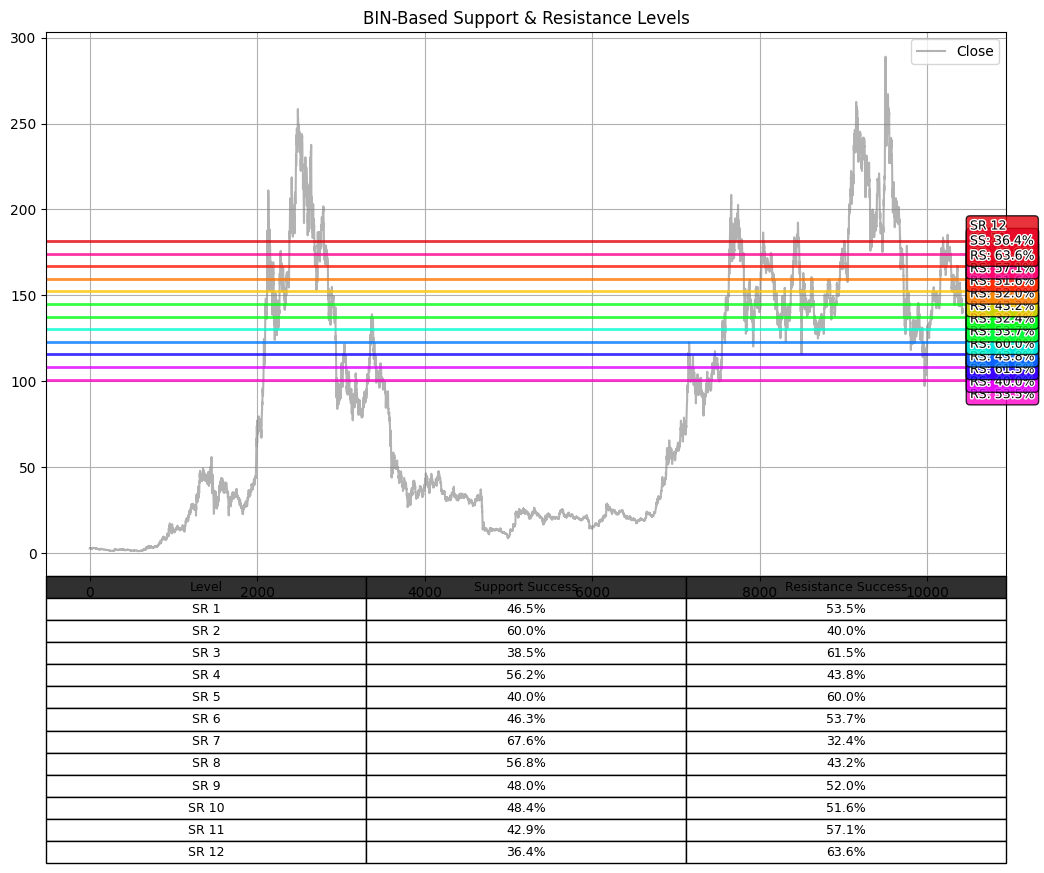

In [ ]:
#
bin_based_sr_plot(
    df=ohlcv,
    lookback=500,
    offset=100,
    display="both",  # options: "label", "table", "both"
    bins=12,         # or use `custom_levels=[...prices...]`
    export_path="sr_levels.png"
)


In [ ]:
import plotly.graph_objects as go


def bin_based_sr_plot_hover(
    df,
    lookback=500,
    offset=100,
    bins=10,
    custom_levels=None,
    display="both"
):
    df = df.copy()
    df = df[-lookback:].reset_index(drop=True)

    high, low, close = df["high"], df["low"], df["close"]

    max_p = close.max()
    min_p = close.min()

    if custom_levels:
        sr_levels = sorted(custom_levels)
        bins = len(sr_levels)
    else:
        step = (max_p - min_p) / bins
        sr_levels = [min_p + step * i for i in range(1, bins + 1)]

    def calculate_stats(level):
        bull_reject = (high.shift(2) >= level) & (close < level)
        bear_reject = (low.shift(2) <= level) & (close > level)
        bull_count = bull_reject.sum()
        bear_count = bear_reject.sum()
        total = bull_count + bear_count
        if total == 0:
            return 0, 0
        return round(bear_count / total * 100, 2), round(bull_count / total * 100, 2)

    support_success = []
    resistance_success = []

    for lvl in sr_levels:
        s, r = calculate_stats(lvl)
        support_success.append(s)
        resistance_success.append(r)

    # Gradient colors from Pine
    gradient_colors = [
        "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
        "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
    ][:bins]

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=close,
        x=df.index,
        mode='lines',
        name='Close',
        line=dict(color='white', width=1)
    ))

    for i, level in enumerate(sr_levels):
        fig.add_trace(go.Scatter(
            x=[0, lookback + offset],
            y=[level, level],
            mode="lines",
            name=f"SR {i+1}",
            line=dict(color=gradient_colors[i], width=2),
            hoverinfo="text",
            hovertext=(
                f"SR Level: {level:.2f}<br>"
                f"Support Success: {support_success[i]}%<br>"
                f"Resistance Success: {resistance_success[i]}%"
            ),
            showlegend=False
        ))

    if display in ["table", "both"]:
        table_data = {
            "SR Level": [f"{lvl:.2f}" for lvl in sr_levels],
            "Support Success (%)": support_success,
            "Resistance Success (%)": resistance_success
        }
        table_df = pd.DataFrame(table_data)
        print(table_df)

    fig.update_layout(
        title="Bin-Based Support and Resistance with Hover Tooltips",
        xaxis_title="Index",
        yaxis_title="Price",
        plot_bgcolor="black",
        paper_bgcolor="black",
        font=dict(color="white")
    )

    return fig


In [ ]:
#
fig = bin_based_sr_plot_hover(ohlcv)
fig.show()

  SR Level  Support Success (%)  Resistance Success (%)
0   106.17                46.67                   53.33
1   114.97                52.38                   47.62
2   123.76                68.75                   31.25
3   132.55                47.06                   52.94
4   141.34                46.67                   53.33
5   150.14                48.48                   51.52
6   158.93                53.33                   46.67
7   167.72                55.26                   44.74
8   176.52                40.91                   59.09
9   185.31                 0.00                  100.00


In [ ]:

def compute_bins(df, lookback=500, num_bins=10):
    recent_data = df.tail(lookback)
    min_price = recent_data['close'].min()
    max_price = recent_data['close'].max()
    bin_edges = np.linspace(min_price, max_price, num_bins + 1)
    return bin_edges


In [ ]:
def group_closes_by_bin(df, bin_edges):
    bin_means = []
    for i in range(len(bin_edges) - 1):
        in_bin = df['close'][(df['close'] >= bin_edges[i]) & (df['close'] < bin_edges[i+1])]
        if not in_bin.empty:
            bin_means.append(in_bin.mean())
        else:
            bin_means.append(None)
    return bin_means


In [ ]:
def calculate_statistics(df, level, lookback):
    highs = df['high'].shift(2)
    lows = df['low'].shift(2)
    closes = df['close']

    bull_rejects = ((highs >= level) & (closes < level)).sum()
    bear_rejects = ((lows <= level) & (closes > level)).sum()

    total = bull_rejects + bear_rejects
    if total == 0:
        return (0.0, 0.0)

    support_success = bear_rejects / total * 100
    resistance_success = bull_rejects / total * 100
    return support_success, resistance_success


In [ ]:
import plotly.graph_objects as go
from plotly.colors import qualitative

def plot_sr_lines(df, bin_levels, support_stats, resistance_stats, colors, offset=100):
    fig = go.Figure()

    # OHLC chart
    fig.add_trace(go.Candlestick(
        x=df.index, open=df['open'], high=df['high'],
        low=df['low'], close=df['close'], name="Price"))

    # Add SR lines
    for i, level in enumerate(bin_levels):
        if level is not None:
            fig.add_trace(go.Scatter(
                x=[df.index[-offset], df.index[-1]],
                y=[level, level],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=2),
                name=f"SR {i+1}",
                hovertemplate=f"<b>SR {i+1}</b><br>Level: {level:.2f}<br>Support Success: {support_stats[i]:.2f}%<br>Resistance Success: {resistance_stats[i]:.2f}%",
                showlegend=False
            ))

    fig.update_layout(title="Gradient SR Lines with Stats", hovermode="x unified")
    return fig


In [ ]:
lookback = 500
bin_edges = compute_bins(ohlcv, lookback)
bin_levels = group_closes_by_bin(ohlcv.tail(lookback), bin_edges)

support_stats, resistance_stats = zip(*[
    calculate_statistics(ohlcv.tail(lookback), level, lookback) if level else (0, 0)
    for level in bin_levels
])


In [ ]:
# Gradient colors similar to Pine Script
colors = [
    '#ff00c8', '#e100ff', '#0d00ff', '#007bff', '#00ffd5',
    '#00ff15', '#00ff15', '#ffc400', '#ff7700', '#ff1500', '#ff008c', '#e3000b'
]

fig = plot_sr_lines(ohlcv, bin_levels, support_stats, resistance_stats, colors)
fig.show()

## Birch Algorithm for Pivots


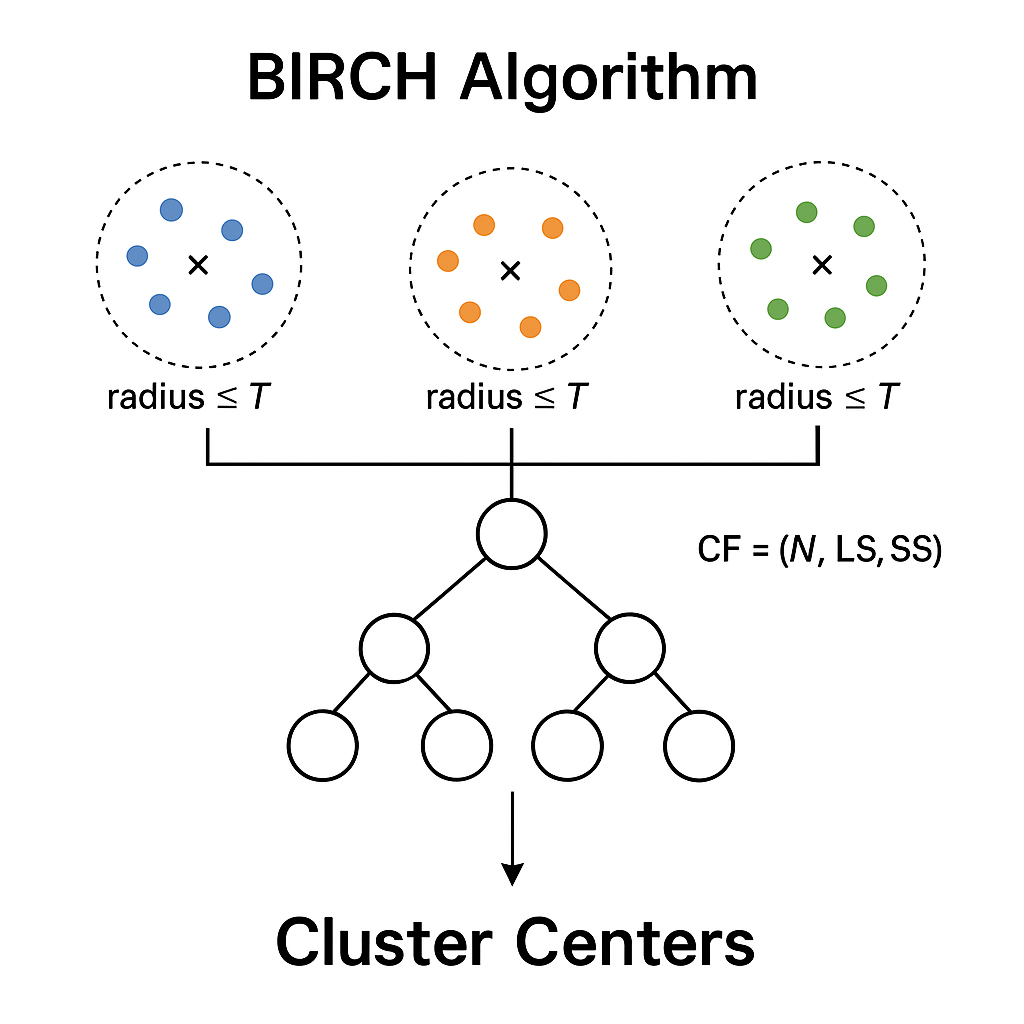


**The Chat**

https://chatgpt.com/c/68380a27-b8e4-8012-91ae-1b0c4348914f


### Normalize price for Birch threshold scaling (Custom Min-Max)

In [ ]:
# === STEP 2: Normalize price for Birch threshold scaling ===
normalized = (prices - prices.min()) / (prices.max() - prices.min())
X = normalized.reshape(-1, 1)

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.09, branching_factor=500, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Normalized": normalized,
    "Cluster": labels
})
df

,Date,Price,Normalized,Cluster
0,2020-09-18 12:00:00,2.8929,0.005881,0
1,2020-09-18 16:00:00,3.1487,0.006770,0
2,2020-09-18 20:00:00,3.0994,0.006599,0
3,2020-09-19 00:00:00,3.1240,0.006684,0
4,2020-09-19 04:00:00,3.1044,0.006616,0
...,...,...,...,...
10416,2025-06-20 20:00:00,140.1900,0.483156,1
10417,2025-06-21 00:00:00,140.8800,0.485554,1
10418,2025-06-21 04:00:00,140.2500,0.483364,1
10419,2025-06-21 08:00:00,142.4900,0.491151,1


In [ ]:
centers

array([0.07209097, 0.54768492, 0.7673733 , 0.34985416, 0.14011514])

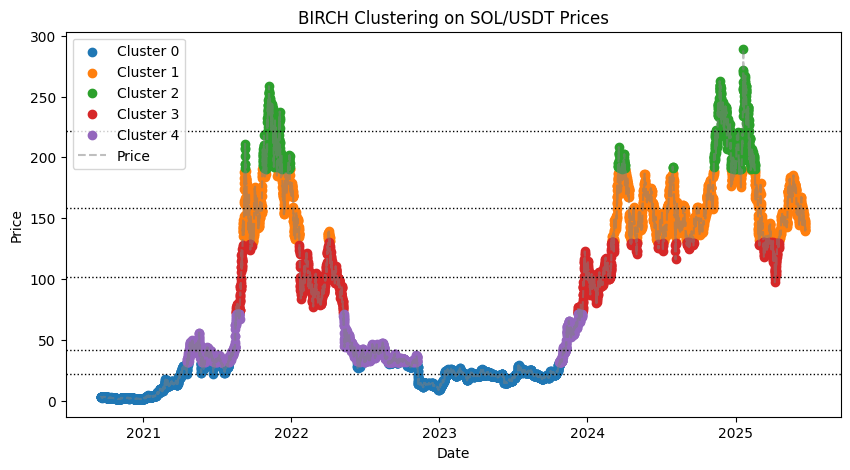

The ATH (last price point) falls into Cluster 1.


In [ ]:
# === STEP 5: Plot the clusters and cluster centers ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot cluster centers as horizontal lines
for cen in centers:
    price_cen = cen * (prices.max() - prices.min()) + prices.min()
    plt.axhline(price_cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on {INSTRUMENT} Prices")
plt.legend()
# plt.tight_layout()
plt.show()

# === STEP 6: Check cluster of last ATH point ===
last_label = labels[-1]
print(f"The ATH (last price point) falls into Cluster {last_label}.")


### BIRCH with raw price threshold

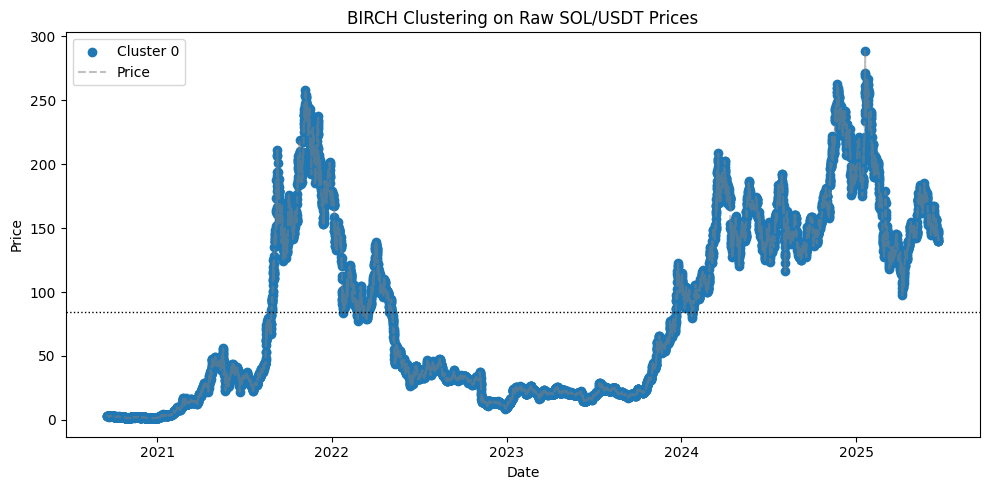

In [ ]:
# === STEP 2: Run BIRCH with raw price threshold ===
# Use an absolute price difference for threshold, e.g., $2,000
model = Birch(threshold=2000, branching_factor=500, n_clusters=None)
model.fit(prices.reshape(-1, 1))
labels = model.predict(prices.reshape(-1, 1))
centers = model.subcluster_centers_.flatten()

# === STEP 3: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices.flatten(),
    "Cluster": labels
})

# === STEP 4: Plot results ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot raw-price cluster centers
for cen in centers:
    plt.axhline(cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on Raw {INSTRUMENT} Prices")
plt.legend()
plt.tight_layout()
plt.show()


### Try price normalization using sklearn's MinMaxScaler

In [ ]:
# === STEP 2: Normalize price using MinMaxScaler ===
scaler = MinMaxScaler()
X = scaler.fit_transform(prices.reshape(-1, 1))

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Denormalize centers for plotting ===
center_prices = scaler.inverse_transform(centers.reshape(-1, 1)).flatten()

# === STEP 5: Prepare DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Cluster": labels
})
df

,Date,Price,Cluster
0,2020-09-18 12:00:00,2.8929,0
1,2020-09-18 16:00:00,3.1487,0
2,2020-09-18 20:00:00,3.0994,0
3,2020-09-19 00:00:00,3.1240,0
4,2020-09-19 04:00:00,3.1044,0
...,...,...,...
10416,2025-06-20 20:00:00,140.1900,6
10417,2025-06-21 00:00:00,140.8800,6
10418,2025-06-21 04:00:00,140.2500,6
10419,2025-06-21 08:00:00,142.4900,6


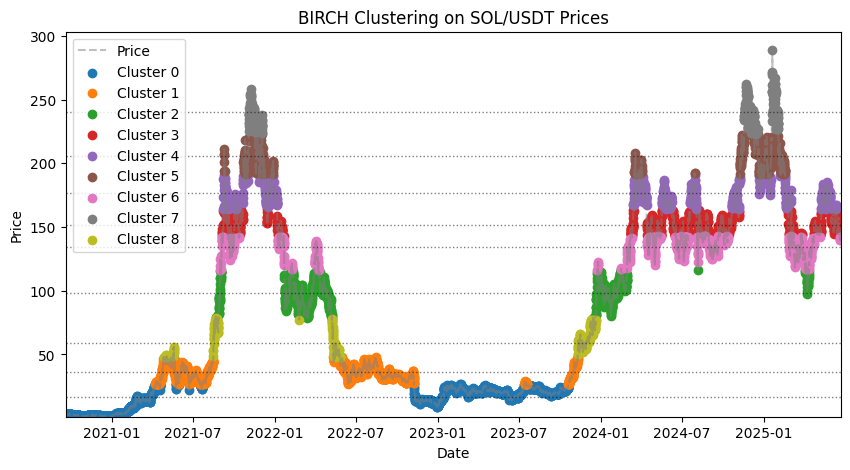

In [ ]:
# === STEP 6: Create static plot ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min() * 0.95, prices.max() * 1.05)
ax.set_title(f"BIRCH Clustering on {INSTRUMENT} Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

# Plot price path
ax.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot clustered points
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(dates[mask], prices[mask], label=f"Cluster {label}")

# Draw support/resistance zones
for cen in center_prices:
    ax.axhline(cen, linestyle=":", linewidth=1, color="black", alpha=0.5)

ax.legend(loc="upper left")
plt.show()

### Use OHLCV Data

Use Mid Prices => (high + low) / 2

Try:

- HLC3 => (high + low + close) / 3

In [ ]:
# === Normalize mid prices ===
mid_prices = ((ohlcv["high"] + ohlcv["low"]) / 2).values.reshape(-1, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(mid_prices)

# === Apply BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=500, n_clusters=None)
model.fit(X)
labels = model.predict(X)

In [ ]:
# model.n_clusters
model.subcluster_labels_

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
model.subcluster_centers_

array([[0.05379836],
       [0.12442804],
       [0.34789336],
       [0.53248135],
       [0.6186459 ],
       [0.71762644],
       [0.47187648],
       [0.84966571],
       [0.20423407]])

In [ ]:
# # Access the micro-clusters
# micro_clusters = model.subcluster_centers_

# # Get the count of points in each micro-cluster
# for i, micro_cluster in enumerate(micro_clusters):
#     count = micro_cluster.n_samples
#     print(f"Micro-cluster {i+1}: {count} points")

In [ ]:
# 4) Retrieve subcluster centers and label mapping
centers_scaled = model.subcluster_centers_
centers = scaler.inverse_transform(centers_scaled).flatten()
label_map = model.subcluster_labels_

label_map

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# 5) Map each predicted label to corresponding cluster center
# label_map[i] tells you the label for subcluster_centers_[i]
# So: for each predicted label in labels, find the corresponding center
mapped_centers = np.array([centers[label_map == lbl][0] for lbl in labels])
mapped_centers

array([ 16.23983777,  16.23983777,  16.23983777, ..., 133.15753777,
       133.15753777, 133.15753777])

In [ ]:
# === Store cluster labels and calculate support/resistance ===
ohlcv["Cluster"] = labels
cluster_supports = ohlcv.groupby("Cluster")["low"].min().values
cluster_resistances = ohlcv.groupby("Cluster")["high"].max().values

In [ ]:
cluster_supports

array([  1.0818,  22.7358,  75.4354, 133.2255, 152.267 , 180.    ,
       110.1   , 214.0003,  43.3974])

In [ ]:
cluster_resistances

array([ 28.    ,  51.5392, 121.9605, 185.8372, 202.1198, 226.1056,
       147.06  , 294.94  ,  83.4399])

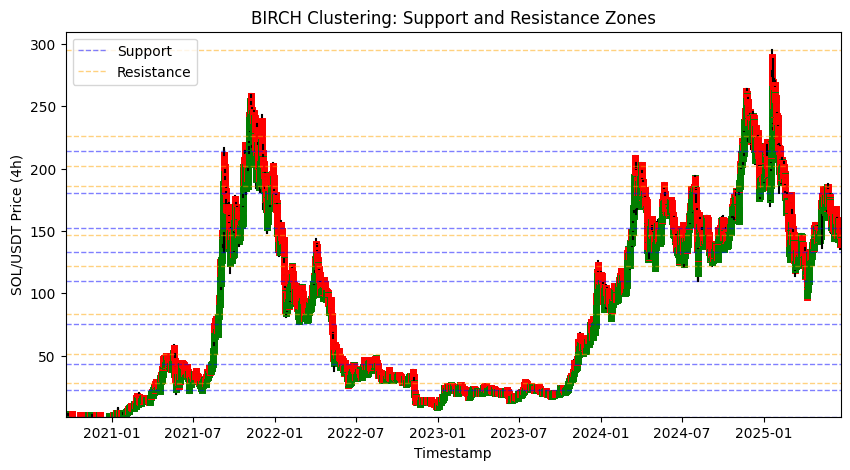

In [ ]:
# === Plot OHLC bars and zone overlays ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(ohlcv["timestamp"].min(), ohlcv["timestamp"].max())
ax.set_ylim(ohlcv["low"].min() * 0.95, ohlcv["high"].max() * 1.05)
ax.set_title("BIRCH Clustering: Support and Resistance Zones")
ax.set_xlabel("Timestamp")
ax.set_ylabel(f"{INSTRUMENT} Price ({TIMEFRAME})")

# Plot OHLC bars for all frames
for i in range(len(ohlcv)):
    color = "green" if ohlcv["close"][i] >= ohlcv["open"][i] else "red"
    ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["low"][i], ohlcv["high"][i]], color="black")
    ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["open"][i], ohlcv["close"][i]], color=color, linewidth=5)

# Plot support and resistance
for support in cluster_supports:
    ax.axhline(support, linestyle="--", color="blue", linewidth=1, alpha=0.5, label="Support")
for resistance in cluster_resistances:
    ax.axhline(resistance, linestyle="--", color="orange", linewidth=1, alpha=0.5, label="Resistance")

# Remove duplicate legend entries
handles, labels_unique = ax.get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left")

plt.show()


# Swing Market Structure

| Concept                         | Description                                                    |
| ------------------------------- | -------------------------------------------------------------- |
| **Swing High / Low**            | Local maxima/minima used to detect trend pivots                |
| **BOS (Break of Structure)**    | Higher high/lower low break confirming trend continuation      |
| **CHoCH (Change of Character)** | First opposite direction break, signaling potential reversal   |
| **Market Trend**                | Determined by consecutive HH/HL or LL/LH sequences             |
| **Liquidity Zones**             | Previous highs/lows, order blocks, or imbalance areas          |
| **Order Blocks (OB)**           | Institutional footprints, often near recent highs/lows or FVGs |
| **FVG (Fair Value Gaps)**       | Price imbalances between candle legs                           |


🔁 Trend + Break of Structure Logic
You can maintain a state machine that:

Tracks current market trend (bullish or bearish).

Compares new swing points to previous ones.

Detects BOS when price breaches the last swing high/low in trend direction.

Detects CHoCH when price breaks a swing in the opposite direction.


Visualization (Plotly or Matplotlib)

You can overlay the swing points and BOS/CHoCH labels on the chart using:

Plotly for interactive web visualizations.

Matplotlib or mplfinance for static Python plots.

In [ ]:
def find_swings(df, left=3, right=3):
    """
    Identify swing highs and lows in OHLC data.
    `left` and `right` define how many bars must be lower/higher around a point.
    """
    df['swing_high'] = df['high'][(df['high'].shift(left) < df['high']) &
                                  (df['high'].shift(-right) < df['high'])]

    df['swing_low'] = df['low'][(df['low'].shift(left) > df['low']) &
                                (df['low'].shift(-right) > df['low'])]

    return df


In [ ]:
def detect_structure(df, left=3, right=3):
    df = find_swings(df, left, right)
    trend = None
    structures = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i-1]

        if trend is None:
            if row['swing_high'] and row['high'] > prev['high']:
                trend = 'bullish'
            elif row['swing_low'] and row['low'] < prev['low']:
                trend = 'bearish'

        elif trend == 'bullish':
            if row['low'] < prev['swing_low']:
                trend = 'bearish'
                structures.append((i, 'CHoCH'))
            elif row['high'] > prev['swing_high']:
                structures.append((i, 'BOS'))

        elif trend == 'bearish':
            if row['high'] > prev['swing_high']:
                trend = 'bullish'
                structures.append((i, 'CHoCH'))
            elif row['low'] < prev['swing_low']:
                structures.append((i, 'BOS'))

    return structures


In [ ]:
structure_df = detect_structure(ohlcv)
pd.DataFrame(structure_df)

,0,1
0,9,CHoCH
1,13,BOS
2,18,BOS
3,21,CHoCH
4,26,BOS
...,...,...
1514,10380,BOS
1515,10391,CHoCH
1516,10397,CHoCH
1517,10403,BOS


## Pattern-based Market Structure

Logic to tag each Order Block (OB) and Fair Value Gap (FVG) with structured labels:

- "untouched" – price hasn’t re-entered the zone

- "mitigated" – price touched the zone

- "invalidated" – price went fully through the zone (e.g. bearish OB broken to the upside)

In [ ]:
def detect_bos_choch(swings, closes=None, mitigation_window=5):
    """
    Detect BOS and CHoCH from swing highs/lows with level and mitigation tracking.

    Args:
        swings (list of tuples): (index, price, 'high' or 'low')
        closes (np.ndarray or list, optional): Close prices (needed for mitigation)
        mitigation_window (int): Look-ahead bars to detect mitigation

    Returns:
        List[dict]: Each entry includes:
            - index: int
            - type: 'BOS' or 'CHoCH'
            - trend: 'bullish' or 'bearish'
            - broken_level: float
            - broken_idx: int
            - mitigated: bool
    """
    structures = []
    trend = None

    for i in range(2, len(swings)):
        idx2, price2, type2 = swings[i - 2]
        idx1, price1, type1 = swings[i - 1]
        idx0, price0, type0 = swings[i]

        # Step 1: Detect initial trend
        if trend is None and type1 != type2:
            if type1 == 'high' and price1 > price2:
                trend = 'bullish'
            elif type1 == 'low' and price1 < price2:
                trend = 'bearish'

        # Step 2: BOS & CHoCH logic
        entry = None

        if trend == 'bullish':
            if type0 == 'low' and price0 < price1:
                # CHoCH: new lower low after bullish structure
                entry = {
                    'index': idx0,
                    'type': 'CHoCH',
                    'trend': 'bearish',
                    'broken_level': price1,
                    'broken_idx': idx1
                }
                trend = 'bearish'
            elif type0 == 'high' and price0 > price1:
                # BOS: higher high
                entry = {
                    'index': idx0,
                    'type': 'BOS',
                    'trend': 'bullish',
                    'broken_level': price1,
                    'broken_idx': idx1
                }

        elif trend == 'bearish':
            if type0 == 'high' and price0 > price1:
                entry = {
                    'index': idx0,
                    'type': 'CHoCH',
                    'trend': 'bullish',
                    'broken_level': price1,
                    'broken_idx': idx1
                }
                trend = 'bullish'
            elif type0 == 'low' and price0 < price1:
                entry = {
                    'index': idx0,
                    'type': 'BOS',
                    'trend': 'bearish',
                    'broken_level': price1,
                    'broken_idx': idx1
                }

        # Step 3: Mitigation detection (if applicable)
        if entry and closes is not None:
            check_start = idx0 + 1
            check_end = min(idx0 + 1 + mitigation_window, len(closes))
            mitigated = False

            if entry['type'] == 'BOS':
                level = entry['broken_level']
                if entry['trend'] == 'bullish':
                    # price returns to old high or below
                    mitigated = any(c <= level for c in closes[check_start:check_end])
                else:
                    # price returns to old low or above
                    mitigated = any(c >= level for c in closes[check_start:check_end])
            else:
                mitigated = False  # mitigation mainly applies to BOS

            entry['mitigated'] = mitigated

        if entry:
            structures.append(entry)

    return structures


In [ ]:
def detect_ob_fvg_zones(df, window=3):
    fvg_zones = []
    ob_zones = []

    threshold = df['close'].pct_change().rolling(window).std().mean() * 2

    # --- FVG detection ---
    for i in range(1, len(df) - 1):
        fvg_type, y0, y1 = None, None, None
        if df['low'].iloc[i + 1] > df['high'].iloc[i - 1]:  # Bullish FVG
            fvg_type = 'Bullish FVG'
            y0, y1 = df['high'].iloc[i - 1], df['low'].iloc[i + 1]
        elif df['high'].iloc[i + 1] < df['low'].iloc[i - 1]:  # Bearish FVG
            fvg_type = 'Bearish FVG'
            y0, y1 = df['high'].iloc[i + 1], df['low'].iloc[i - 1]

        if fvg_type:
            post_range = df.iloc[i+2:]
            mitigated = (
                (post_range['low'] <= y1) & (post_range['low'] >= y0)
            ).any() if fvg_type == 'Bullish FVG' else (
                (post_range['high'] >= y0) & (post_range['high'] <= y1)
            ).any()

            invalidated = (
                (post_range['low'] < y0)
            ).any() if fvg_type == 'Bullish FVG' else (
                (post_range['high'] > y1)
            ).any()

            status = "untouched"
            if mitigated:
                status = "mitigated"
            if invalidated:
                status = "invalidated"

            fvg_zones.append({
                "type": fvg_type,
                "start_idx": i,
                "x0": df.index[i - 1],
                "x1": df.index[-1],
                "y0": y0,
                "y1": y1,
                "status": status
            })

    # --- OB detection ---
    for i in range(2, len(df) - 3):
        ob_type, y0, y1 = None, None, None

        if df['close'].iloc[i] < df['open'].iloc[i] and df['close'].iloc[i + 2] > df['close'].iloc[i] + threshold:
            ob_type = 'Bullish OB'
            y0, y1 = df['low'].iloc[i], df['high'].iloc[i]
        elif df['close'].iloc[i] > df['open'].iloc[i] and df['close'].iloc[i + 2] < df['close'].iloc[i] - threshold:
            ob_type = 'Bearish OB'
            y0, y1 = df['low'].iloc[i], df['high'].iloc[i]

        if ob_type:
            post = df.iloc[i+2:]
            if ob_type == 'Bullish OB':
                touched = (post['low'] >= y0) & (post['low'] <= y1)
                invalidated = (post['low'] < y0).any()
            else:
                touched = (post['high'] >= y0) & (post['high'] <= y1)
                invalidated = (post['high'] > y1).any()

            mitigated = touched.any()
            status = "untouched"
            if mitigated:
                status = "mitigated"
            if invalidated:
                status = "invalidated"

            ob_zones.append({
                "type": ob_type,
                "start_idx": i,
                "x0": df.index[i],
                "x1": df.index[-1],
                "y0": y0,
                "y1": y1,
                "status": status
            })

    return pd.DataFrame(ob_zones), pd.DataFrame(fvg_zones)


In [ ]:
ob_df, fvg_df = detect_ob_fvg_zones(ohlcv)

# View all Bearish OBs that were invalidated
ob_df[(ob_df['type'] == 'Bearish OB') & (ob_df['status'] == 'invalidated')]

,type,start_idx,x0,x1,y0,y1,status
0,Bearish OB,3,3,10420,3.0946,3.2430,invalidated
2,Bearish OB,10,10,10420,2.9052,2.9287,invalidated
4,Bearish OB,15,15,10420,2.9236,3.0116,invalidated
6,Bearish OB,21,21,10420,2.7407,2.9569,invalidated
8,Bearish OB,25,25,10420,2.9094,2.9785,invalidated
...,...,...,...,...,...,...,...
4855,Bearish OB,10357,10357,10420,163.5300,167.2400,invalidated
4860,Bearish OB,10374,10374,10420,144.9700,148.9300,invalidated
4863,Bearish OB,10388,10388,10420,155.7400,157.7000,invalidated
4872,Bearish OB,10404,10404,10420,144.4200,147.8000,invalidated


In [ ]:
fvg_df

,type,start_idx,x0,x1,y0,y1,status
0,Bearish FVG,4,3,10420,3.0845,3.0946,invalidated
1,Bearish FVG,7,6,10420,2.9979,3.0077,invalidated
2,Bearish FVG,8,7,10420,3.0021,3.0209,invalidated
3,Bearish FVG,9,8,10420,2.9287,2.9742,invalidated
4,Bearish FVG,11,10,10420,2.8500,2.9052,invalidated
...,...,...,...,...,...,...,...
2492,Bearish FVG,10395,10394,10420,151.3700,152.4800,untouched
2493,Bearish FVG,10396,10395,10420,150.1500,150.4100,untouched
2494,Bearish FVG,10401,10400,10420,146.5800,146.6500,invalidated
2495,Bearish FVG,10414,10413,10420,143.0200,147.0600,untouched


In [ ]:
# Save to CSV
ob_df.to_csv("order_blocks_labeled.csv", index=False)
fvg_df.to_csv("fvg_labeled.csv", index=False)

In [ ]:
import plotly.graph_objects as go

def plot_market_structure(df, nodes, alerts, structures, window=1,
                          plot_fvg=True, plot_ob=True, volume_overlay=True,
                          show_only_mitigated_bos=False):

    fig = go.Figure()

    highs = df['high'].values
    lows = df['low'].values
    closes = df['close'].values

    # --- Candlestick ---
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'], high=df['high'],
        low=df['low'], close=df['close'],
        name='Price'
    ))

    swing_highs = [i for i in nodes if highs[i] > highs[i - window] and highs[i] > highs[i + window]]
    swing_lows = [i for i in nodes if lows[i] < lows[i - window] and lows[i] < lows[i + window]]

    # --- Swing points ---
    fig.add_trace(go.Scatter(
        x=df.index[swing_highs],
        y=highs[swing_highs],
        mode='markers',
        marker=dict(color='blue', symbol='triangle-down', size=10),
        name='Swing Highs'
    ))

    fig.add_trace(go.Scatter(
        x=df.index[swing_lows],
        y=lows[swing_lows],
        mode='markers',
        marker=dict(color='orange', symbol='triangle-up', size=10),
        name='Swing Lows'
    ))

    # --- Alerts ---
    fig.add_trace(go.Scatter(
        x=df.index[alerts],
        y=closes[alerts],
        mode='markers',
        marker=dict(color='red', size=12, symbol='star'),
        name='Reversal Alerts'
    ))

    # --- BOS / CHoCH lines ---
    recent_swing_range = (min(closes[nodes[-5:]]), max(closes[nodes[-5:]])) if len(nodes) >= 5 else (min(closes), max(closes))

    for s in structures:
        if show_only_mitigated_bos and (s['type'] != 'BOS' or not s.get('mitigated')):
            continue

        x0 = df.index[s['broken_idx']]
        x1 = df.index[s['index']]
        y = s['broken_level']
        color = 'green' if s['type'] == 'BOS' else 'red'
        label = f"{s['type']}<br>{s['trend']}<br>{'Mitigated' if s.get('mitigated') else 'Clean'}"

        # Detect internal BOS
        if s['type'] == 'BOS':
            if s['broken_level'] >= recent_swing_range[0] and s['broken_level'] <= recent_swing_range[1]:
                label += "<br><b>Internal BOS</b>"
            else:
                label += "<br><b>External BOS</b>"

        # Line from broken swing to break
        fig.add_shape(
            type='line',
            x0=x0, x1=x1,
            y0=y, y1=y,
            line=dict(color=color, width=2, dash='dash'),
            layer='above'
        )

        fig.add_annotation(
            x=x1,
            y=y,
            text=label,
            showarrow=True,
            arrowhead=3,
            font=dict(size=10, color=color),
            bgcolor='white',
            ax=0,
            ay=-30 if s['type'] == 'BOS' else 30
        )

    # --- Fair Value Gaps (FVG) ---
    if plot_fvg:
        for i in range(1, len(df) - 1):
            fvg_type = None
            y0, y1 = None, None

            if df['low'].iloc[i + 1] > df['high'].iloc[i - 1]:  # Bullish FVG
                y0, y1 = df['high'].iloc[i - 1], df['low'].iloc[i + 1]
                fvg_type = 'Bullish FVG'
                color = 'rgba(0,255,0,0.1)'
            elif df['high'].iloc[i + 1] < df['low'].iloc[i - 1]:  # Bearish FVG
                y0, y1 = df['high'].iloc[i + 1], df['low'].iloc[i - 1]
                fvg_type = 'Bearish FVG'
                color = 'rgba(255,0,0,0.1)'

            if fvg_type:
                fig.add_shape(
                    type='rect',
                    x0=df.index[i - 1], x1=df.index[-1],
                    y0=y0, y1=y1,
                    fillcolor=color,
                    line=dict(color='gray', width=0),
                    layer='below'
                )

                mid_time = df.index[i]
                mid_price = (y0 + y1) / 2
                fig.add_trace(go.Scatter(
                    x=[mid_time],
                    y=[mid_price],
                    mode='markers',
                    marker=dict(size=1, opacity=0),
                    hoverinfo='text',
                    hovertext=f"{fvg_type}<br>Gap: {y0:.2f} → {y1:.2f}",
                    showlegend=False
                ))

                # Mitigation
                post_prices = df['low'].iloc[i+2:] if 'Bullish' in fvg_type else df['high'].iloc[i+2:]
                mitigated = any((post_prices < y1) & (post_prices > y0)) if 'Bullish' in fvg_type else any((post_prices > y0) & (post_prices < y1))
                if mitigated:
                    fig.add_annotation(
                        x=mid_time,
                        y=mid_price,
                        text='FVG Filled',
                        showarrow=False,
                        font=dict(size=10, color='darkgreen'),
                        bgcolor='rgba(200,255,200,0.8)'
                    )

    # --- Order Blocks (OB) ---
    if plot_ob:
        threshold = df['close'].pct_change().rolling(3).std().mean() * 2
        for i in range(2, len(df) - 3):
            ob_type = None
            color = None

            if df['close'].iloc[i] < df['open'].iloc[i] and df['close'].iloc[i + 2] > df['close'].iloc[i] + threshold:
                ob_type = 'Bullish OB'
                color = 'rgba(0,128,255,0.15)'
            elif df['close'].iloc[i] > df['open'].iloc[i] and df['close'].iloc[i + 2] < df['close'].iloc[i] - threshold:
                ob_type = 'Bearish OB'
                color = 'rgba(255,0,128,0.15)'

            if ob_type:
                x0 = df.index[i]
                x1 = df.index[-1]
                y0 = df['low'].iloc[i]
                y1 = df['high'].iloc[i]
                mid_time = x0
                mid_price = (y0 + y1) / 2

                fig.add_shape(
                    type='rect',
                    x0=x0, x1=x1,
                    y0=y0, y1=y1,
                    fillcolor=color,
                    line=dict(color='gray', width=1),
                    layer='below'
                )

                fig.add_trace(go.Scatter(
                    x=[mid_time],
                    y=[mid_price],
                    mode='markers',
                    marker=dict(size=1, opacity=0),
                    hoverinfo='text',
                    hovertext=f"{ob_type}<br>Zone: {y0:.2f} → {y1:.2f}",
                    showlegend=False
                ))

                if ob_type == 'Bullish OB':
                    post_lows = df['low'].iloc[i+2:]
                    mitigated = any((post_lows >= y0) & (post_lows <= y1))
                else:
                    post_highs = df['high'].iloc[i+2:]
                    mitigated = any((post_highs >= y0) & (post_highs <= y1))

                if mitigated:
                    fig.add_annotation(
                        x=mid_time,
                        y=mid_price,
                        text='OB Mitigated',
                        showarrow=False,
                        font=dict(size=10, color='black'),
                        bgcolor='rgba(255,255,128,0.8)'
                    )

    # --- Volume Overlay ---
    if volume_overlay:
        fig.add_trace(go.Bar(
            x=df.index,
            y=df['volume'],
            yaxis='y2',
            marker=dict(color='rgba(100,100,100,0.3)'),
            name='Volume',
            opacity=0.4
        ))
        fig.update_layout(
            yaxis2=dict(
                overlaying='y',
                side='right',
                showgrid=False,
                title='Volume',
                range=[0, df['volume'].max() * 4]
            )
        )

    fig.update_layout(
        title='Market Structure + FVG + OB + Volume',
        xaxis_title='Time',
        yaxis_title='Price',
        template='plotly_white',
        height=800
    )
    fig.show()


In [ ]:
def plot_market_structure_from_displacements(df, window=2, mitigation_window=5,
                                             plot_fvg=True, plot_ob=True,
                                             volume_overlay=True,
                                             show_only_mitigated_bos=False):
    """
    Fully modular market structure plot using detection functions.
    Requires:
        - detect_nodal_displacements()
        - detect_bos_choch()

    Args:
        df (pd.DataFrame): Must contain ['open', 'high', 'low', 'close', 'volume']
    """
    # 1. Detect nodes, displacements, reversal alerts, and BOS/CHoCH
    nodes, displacements, alerts, structures = detect_nodal_displacements(
        highs=df['high'].values,
        lows=df['low'].values,
        closes=df['close'].values,
        window=window,
        mitigation_window=mitigation_window
    )

    # 2. Pass detection results to simplified plotting core
    plot_market_structure(
        df=df,
        nodes=nodes,
        alerts=alerts,
        structures=structures,
        window=window,
        plot_fvg=plot_fvg,
        plot_ob=plot_ob,
        volume_overlay=volume_overlay,
        show_only_mitigated_bos=show_only_mitigated_bos
    )


# plot_market_structure_from_displacements(
#     ohlcv,
#     window=cycle_window,
#     mitigation_window=5,
#     plot_fvg=True,
#     plot_ob=True,
#     show_only_mitigated_bos=True
# )


# Market Cycle Algorithms (Mathematical Model of Market Structure)

Cycle(C) = Rally + Correction

Correction Factor(Kn) = αRn

Composite Cycles = {C1 + C2 + C3 + ... + Cn}


Rallies and Corrections Detection

lower alpha -> strong trend

Higher alpha -> weaker trend



**TODO: Put alpha in a suitable scale, the paper suggests 0-1**

Balance alpha scale by dividing alphas > 1 with 10


windows = 2, 3, 4



**Market Cycle Analyzer**


🔁 What Does “Rolling Windows” Mean?

In live or forward-looking systems, **market behavior changes over time**. If you train your model on all past data, you risk becoming **outdated**.

✅ Rolling Window = Only use recent cycles

Instead of using all past cycles, only keep:

```python
last_k = 100  # last 100 cycles
X_recent = X[-last_k:]
y_recent = y[-last_k:]
model.fit(X_recent, y_recent)
```

🔁 Why it helps:

* **Adapts to new market conditions**
* Reduces overfitting to outdated behavior
* Essential for **live trading models**



In [ ]:
def detect_cycles(highs, lows, prices, window=3, slope_threshold=0.1):
    """
    Detects rally-correction cycles using higher highs/lows + slope validation.
    Computes alpha (correction/rally) and net movement for each complete cycle.

    Args:
        highs (np.ndarray): High prices
        lows (np.ndarray): Low prices
        prices (np.ndarray): Closing prices (used for slope computation)
        window (int): Number of bars to evaluate structure
        slope_threshold (float): Minimum slope to validate trend

    Returns:
        rallies (list): Indices of rally end points
        corrections (list): Indices of correction end points
        slopes (list): All computed slopes
        alphas (list): Correction / Rally ratios
        net_movements (list): R + K for each cycle
    """
    rallies = []
    corrections = []
    slopes = []
    alphas = []
    net_movements = []

    for i in range(window, len(prices)):
        high_seq = highs[i - window + 1:i + 1]
        low_seq = lows[i - window + 1:i + 1]
        price_seq = prices[i - window + 1:i + 1]

        x = np.arange(window)
        slope = np.polyfit(x, price_seq, 1)[0]
        slopes.append(slope)

        if all(x < y for x, y in zip(high_seq, high_seq[1:])) and \
           all(x < y for x, y in zip(low_seq, low_seq[1:])) and slope > slope_threshold:
            rallies.append(i)

        elif all(x > y for x, y in zip(high_seq, high_seq[1:])) and \
             all(x > y for x, y in zip(low_seq, low_seq[1:])) and slope < -slope_threshold:
            corrections.append(i)

            # Check for a previous rally to pair with this correction
            if rallies and rallies[-1] < i:
                rally_end_idx = rallies[-1]
                correction_end_idx = i

                rally_start_price = prices[rally_end_idx - window + 1]
                rally_end_price = prices[rally_end_idx]
                correction_end_price = prices[correction_end_idx]

                R = rally_end_price - rally_start_price
                K = correction_end_price - rally_end_price

                # Calculate alpha and scale if greater than 1
                alpha = abs(K) / R if R != 0 else 0
                # if alpha > 1:
                #   alpha /= 10 # something is missing here, probably 1 - alpha/10
                net_movement = R + K

                # alphas.append(np.round(alpha, 4))
                # net_movements.append(np.round(net_movement, 4))
                # Extract the scalar value from the NumPy array before rounding
                alphas.append(round(alpha.item() if isinstance(alpha, np.ndarray) else alpha, 4))
                net_movements.append(round(net_movement.item() if isinstance(net_movement, np.ndarray) else net_movement, 4))

    return rallies, corrections, slopes, alphas, net_movements


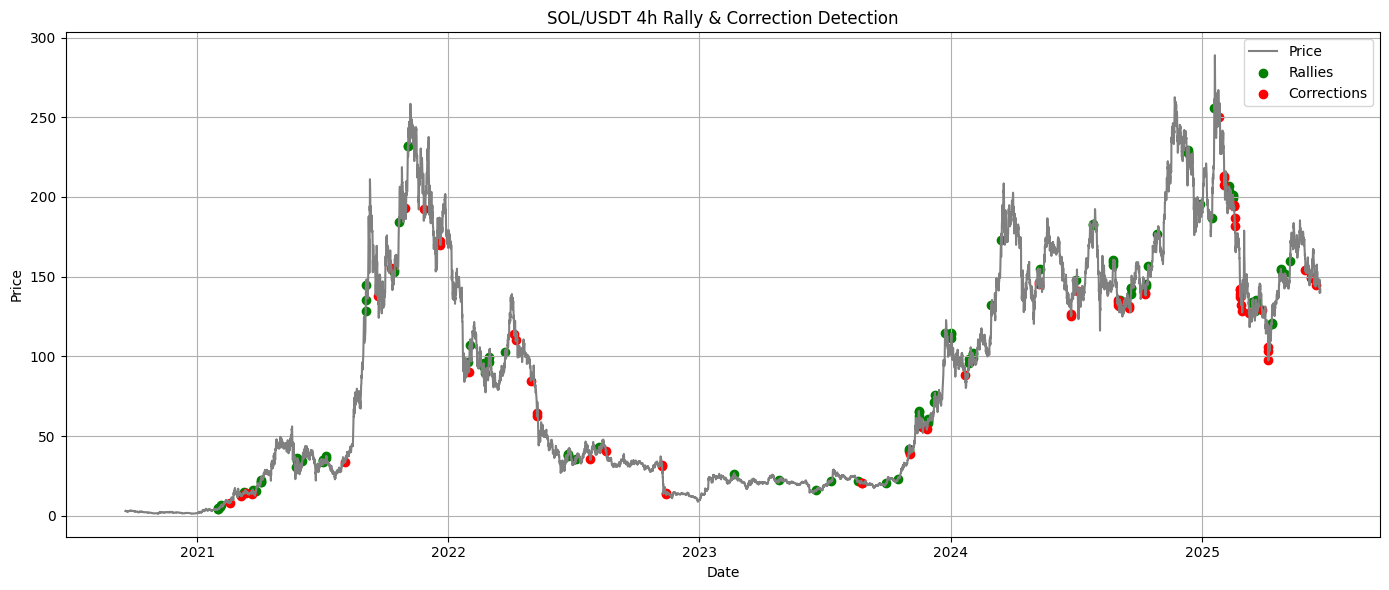

In [ ]:
# --- Step 3: Apply detection ---
cycle_window = 6
rallies, corrections, slopes, alphas, net_movements = detect_cycles(highs, lows, closes, window=cycle_window)

# --- Step 3.5: Scale the alphas to the range [0, 1] ---
if alphas: # Check if alphas list is not empty
    alpha_scaler = MinMaxScaler()
    alphas_scaled = alpha_scaler.fit_transform(np.array(alphas).reshape(-1, 1))
    # Replace the original alphas list with the scaled ones
    alphas = alphas_scaled.flatten().tolist() # Flatten and convert back to list

# --- Step 4: Plot the results ---
plt.figure(figsize=(14, 6))
# Use dates for the x-axis
plt.plot(dates, prices, label="Price", color="gray")
plt.scatter(dates[rallies], prices[rallies], color='green', label="Rallies")
plt.scatter(dates[corrections], prices[corrections], color='red', label="Corrections")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.title(f"{INSTRUMENT.replace('-', '/')} {TIMEFRAME} Rally & Correction Detection")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
len(alphas), len(net_movements)

(66, 66)

In [ ]:
len(rallies), len(corrections), len(slopes)

(111, 66, 10415)

In [ ]:
# # Optional: print cycle metrics
# for i, (a, nm) in enumerate(zip(alphas, net_movements), 1):
#     print(f"Cycle {i}: α = {a}, Net Movement = {nm}")

# Create a pandas DataFrame
cycle_data = pd.DataFrame({
    'Cycle': range(1, len(alphas) + 1),
    'Alpha': alphas,
    'Net Movement': net_movements
})

cycle_data

,Cycle,Alpha,Net Movement
0,1,0.102636,2.1823
1,2,0.501841,6.7280
2,3,0.065144,0.2394
3,4,0.109866,-0.2207
4,5,0.111623,-0.8344
...,...,...,...
61,62,0.380113,-29.2300
62,63,0.036879,8.1900
63,64,0.068028,3.2400
64,65,0.066333,3.5100


Average Cycle Length: 157.8939393939394



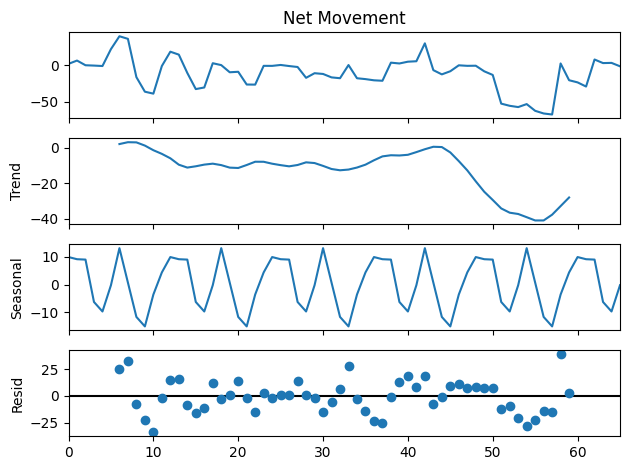

In [ ]:
#@title Cycle Length

from statsmodels.tsa.seasonal import seasonal_decompose

print(f"Average Cycle Length: {len(prices) / len(alphas)}\n")

# Assuming 'Net Movement' is the time series data and the index is the time component.
# If the index is not already a datetime index, you may need to create one.
# For example, if 'Cycle' represents months or quarters:
# cycle_data = cycle_data.set_index(pd.to_datetime(cycle_data['Cycle'], unit='M')) # or 'Q' for quarters

# Perform seasonal decomposition
result = seasonal_decompose(cycle_data['Net Movement'], model='additive', period=12) # Assuming yearly seasonality (period=12 for monthly data)

# Plot the decomposed components to visualize seasonality
result.plot()

# You can also access the seasonal component directly
seasonal_component = result.seasonal

# Further analysis can be done on the seasonal component to confirm patterns.

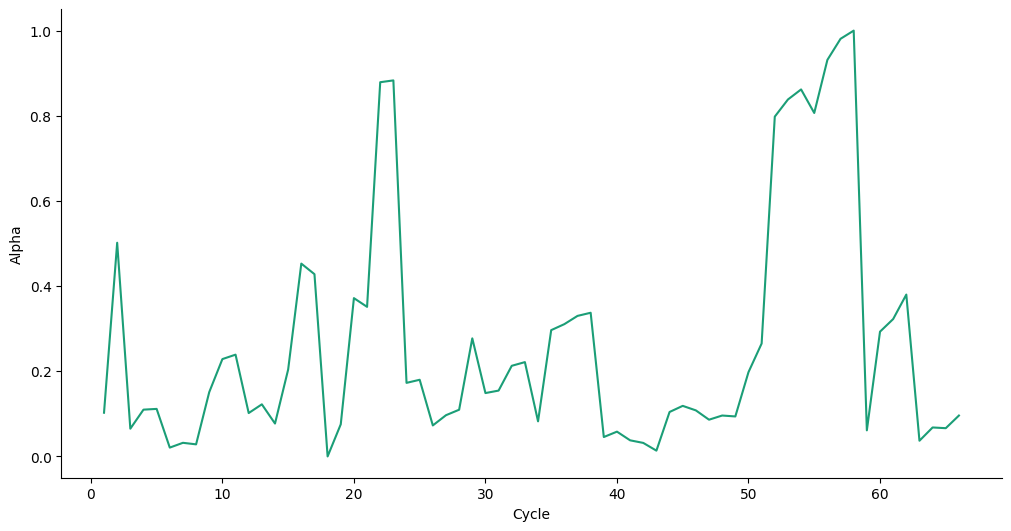

In [ ]:
# @title Cycle vs Alpha

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Alpha']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Alpha')

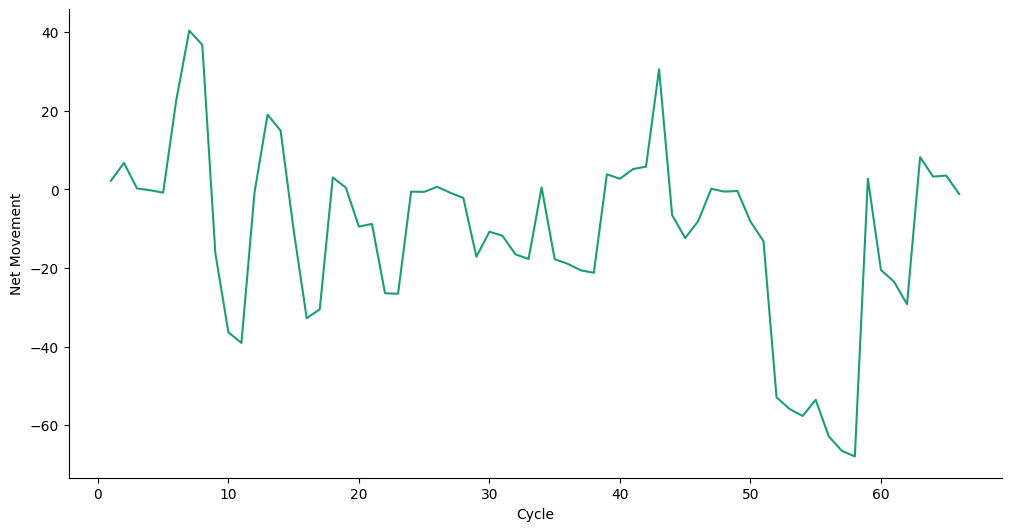

In [ ]:
# @title Cycle vs Net Movement

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Net Movement']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Net Movement')

### Nested Cycle Formation

In [ ]:
def compute_composite_cycles(net_movements):
    """
    Computes composite cycle values (cumulative net movement) from detect_cycles output.

    Args:
        net_movements (list): Output from detect_cycles (R + K per cycle)

    Returns:
        composite_cycles (list): Cumulative net movement (composite cycle)
    """
    return np.cumsum(net_movements).tolist()


In [ ]:
# Now compute composite cycle
composite_cycles = compute_composite_cycles(net_movements)

# Print results
for i, (alpha, net, comp) in enumerate(zip(alphas, net_movements, composite_cycles), 1):
    print(f"Cycle {i}: α = {alpha}, Net = {net}, Composite = {comp}")

Cycle 1: α = 0.10263575794675255, Net = 2.1823, Composite = 2.1823
Cycle 2: α = 0.5018408609018887, Net = 6.728, Composite = 8.9103
Cycle 3: α = 0.06514429687985167, Net = 0.2394, Composite = 9.1497
Cycle 4: α = 0.10986612727224336, Net = -0.2207, Composite = 8.928999999999998
Cycle 5: α = 0.11162270779549144, Net = -0.8344, Composite = 8.094599999999998
Cycle 6: α = 0.020741844764414163, Net = 22.5748, Composite = 30.669399999999996
Cycle 7: α = 0.03199992902704956, Net = 40.3709, Composite = 71.0403
Cycle 8: α = 0.028371436936097727, Net = 36.7633, Composite = 107.8036
Cycle 9: α = 0.1510215669053132, Net = -16.2343, Composite = 91.5693
Cycle 10: α = 0.22859500172996564, Net = -36.3514, Composite = 55.2179
Cycle 11: α = 0.23901915382499841, Net = -39.0551, Composite = 16.162799999999997
Cycle 12: α = 0.10187279872958417, Net = -0.8266, Composite = 15.336199999999998
Cycle 13: α = 0.12236623816747841, Net = 18.9926, Composite = 34.3288
Cycle 14: α = 0.0772274416912854, Net = 14.937, C

In [ ]:
cycle_data['Composite Cycle'] = composite_cycles
cycle_data

,Cycle,Alpha,Net Movement,Composite Cycle
0,1,0.102636,2.1823,2.1823
1,2,0.501841,6.7280,8.9103
2,3,0.065144,0.2394,9.1497
3,4,0.109866,-0.2207,8.9290
4,5,0.111623,-0.8344,8.0946
...,...,...,...,...
61,62,0.380113,-29.2300,-736.3515
62,63,0.036879,8.1900,-728.1615
63,64,0.068028,3.2400,-724.9215
64,65,0.066333,3.5100,-721.4115


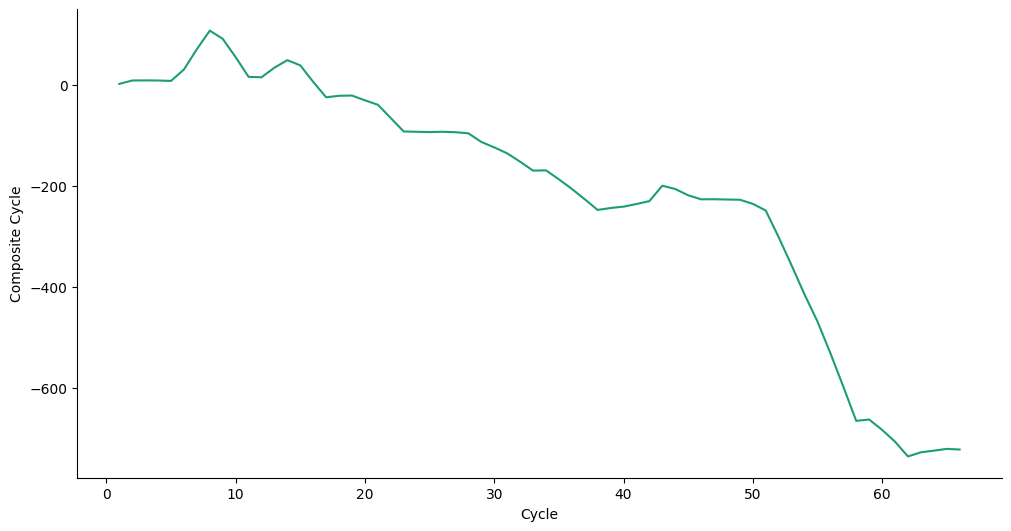

In [ ]:
# @title Cycle vs Composite Cycle

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Composite Cycle']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Composite Cycle')

## Nodal Points and Market Reversals


If nodal displacements shrink while composite cycle magnitude increases, a trend reversal may be approaching.

Then:

- Price is moving less between swing points

- But the cycle-based trend is still rising

This suggests divergence — momentum is weakening while structure is still pushing forward → reversal risk increases.


| Concept                       | Meaning                                  |
| ----------------------------- | ---------------------------------------- |
| Large composite cycle         | Trend is still structurally progressing  |
| Shrinking nodal displacements | Individual swings are getting weaker     |
| Combined message              | Trend is **exhausting**; reversal likely |


This is similar to momentum divergence in technical analysis, but it's derived from structural cycle behavior.


| Term                    | Meaning                             |
| ----------------------- | ----------------------------------- |
| Nodal point             | Local high/low swing                |
| Nodal displacement      | Price move between nodes            |
| Shrinking displacements | Sign of weakening trend             |
| Rising composite cycle  | Trend is still intact structurally  |
| Combined = reversal     | Trend may reverse due to exhaustion |


In [ ]:
# def detect_nodal_displacements(highs, lows, closes, window=1):
#     """
#     Detects nodal points (local highs/lows), computes displacements, and triggers reversal alerts.

#     Args:
#         prices (np.ndarray): Series of price values (e.g., closes)
#         window (int): Number of bars to check on each side for local extrema

#     Returns:
#         nodes (list): Indices of detected nodal points (swing highs/lows)
#         displacements (list): List of nodal displacements (ΔP)
#         alerts (list): Indices where reversal conditions are met
#     """
#     nodes = []
#     displacements = []
#     alerts = []

#     # Step 1: Detect nodal points (extrema)
#     for i in range(window, len(prices) - window):
#         if highs[i] > highs[i - window] and highs[i] > highs[i + window]:
#             nodes.append(i)  # local high
#         elif lows[i] < lows[i - window] and lows[i] < lows[i + window]:
#             nodes.append(i)  # local low

#     # Step 2: Compute nodal displacements
#     for i in range(1, len(nodes)):
#         disp = prices[nodes[i]] - prices[nodes[i - 1]]
#         displacements.append(disp)

#     # Step 3: Alert if displacements are shrinking but composite is growing
#     for i in range(2, len(displacements)):
#         prev_disp = abs(displacements[i - 1])
#         curr_disp = abs(displacements[i])
#         composite_now = abs(displacements[i - 1] + displacements[i])
#         composite_before = abs(displacements[i - 1])

#         if curr_disp < prev_disp and composite_now > composite_before:
#             alerts.append(nodes[i])

#     return nodes, displacements, alerts


def detect_nodal_displacements(highs, lows, closes, window=1, mitigation_window=5):
    """
    Detects:
        - Nodal points (local highs/lows)
        - Nodal displacements
        - Reversal alerts
        - BOS/CHoCH structure changes

    Args:
        highs, lows, closes (np.ndarray): Price series
        window (int): Local extrema window
        mitigation_window (int): # bars to check for mitigation after BOS

    Returns:
        nodes: list of indices of nodal points
        displacements: list of ΔP between nodes
        alerts: list of indices where reversal condition met
        structures: list of BOS/CHoCH dicts with mitigation info
    """
    nodes = []
    displacements = []
    alerts = []
    swings = []

    # Step 1: Detect local highs/lows
    for i in range(window, len(closes) - window):
        if highs[i] > highs[i - window] and highs[i] > highs[i + window]:
            nodes.append(i)
            swings.append((i, highs[i], 'high'))
        elif lows[i] < lows[i - window] and lows[i] < lows[i + window]:
            nodes.append(i)
            swings.append((i, lows[i], 'low'))

    # Step 2: Displacements
    for i in range(1, len(nodes)):
        disp = closes[nodes[i]] - closes[nodes[i - 1]]
        displacements.append(disp)

    # Step 3: Alerts based on reversal heuristic
    for i in range(2, len(displacements)):
        prev_disp = abs(displacements[i - 1])
        curr_disp = abs(displacements[i])
        composite_now = abs(displacements[i - 1] + displacements[i])
        composite_before = abs(displacements[i - 1])

        if curr_disp < prev_disp and composite_now > composite_before:
            alerts.append(nodes[i])

    # Step 4: Structure detection using swings
    structures = detect_bos_choch(swings, closes=closes, mitigation_window=mitigation_window)

    return nodes, displacements, alerts, structures


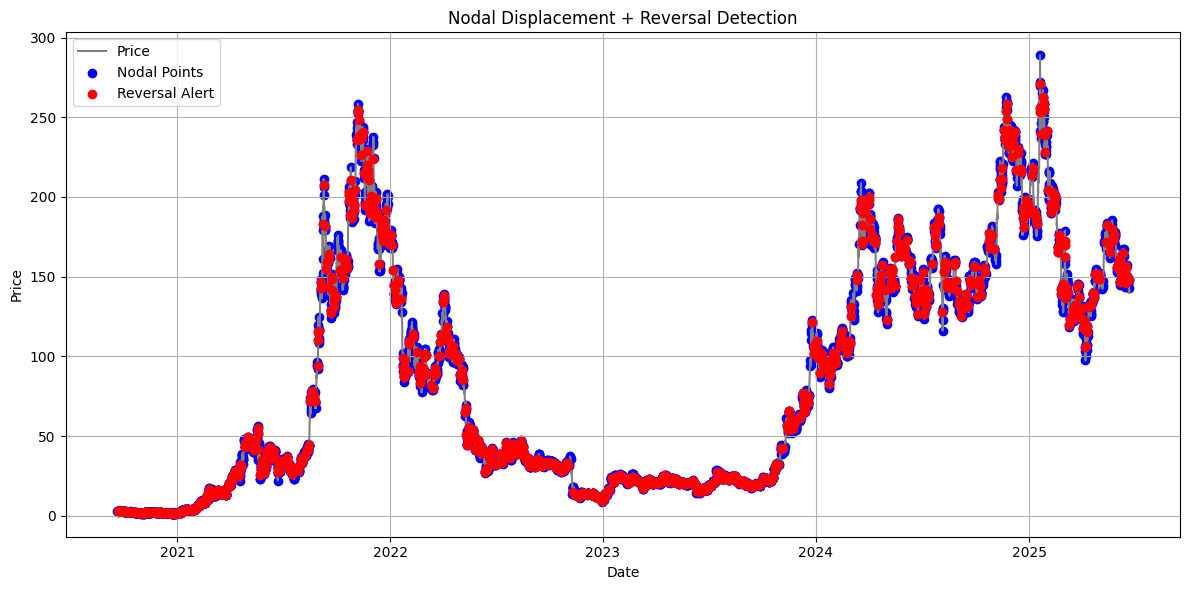

In [ ]:
# Run nodal detection
nodes, displacements, alerts, structures = detect_nodal_displacements(highs, lows, closes, window=cycle_window)

# Plot
plt.figure(figsize=(12, 6))
# Use dates for the x-axis
plt.plot(dates, prices, label="Price", color="gray")
# Use dates corresponding to the nodes for the x-axis
plt.scatter(dates[nodes], prices[nodes], color="blue", label="Nodal Points")
# Use dates corresponding to the alerts for the x-axis
plt.scatter(dates[alerts], prices[alerts], color="red", label="Reversal Alert", zorder=5)
plt.title("Nodal Displacement + Reversal Detection")
plt.xlabel("Date") # Change xlabel to Date
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Print insights
# for i, (n, d) in enumerate(zip(nodes[1:], displacements)):
#     print(f"Node {i+1}: ΔP = {d:.2f}")

# Create a list of dictionaries to hold the data for each row
table_data = []
for i, (n, d) in enumerate(zip(nodes[1:], displacements)):
    table_data.append({
        "Node": f"{i+1}",
        "ΔP": d
    })

# Create the pandas DataFrame
df_insights = pd.DataFrame(table_data)

# Print the DataFrame
df_insights

,Node,ΔP
0,1,-0.1413
1,2,0.2339
2,3,-0.4202
3,4,0.0964
4,5,0.1427
...,...,...
5228,5229,0.1800
5229,5230,-1.2500
5230,5231,2.5100
5231,5232,0.5000


In [ ]:
# for idx in alerts:
#     print(f"🔺 Reversal Alert at index {dates[idx]} (Price = {prices[idx]})")

# Create a list of dictionaries to hold the data for each row
table_data = []
for idx in alerts:
    table_data.append({
        # "Alert Index": idx,
        "Date": dates[idx],
        "Price": prices[idx]
    })

# Create the pandas DataFrame
df_alerts = pd.DataFrame(table_data)

# Print the DataFrame
df_alerts

,Date,Price
0,2020-09-21 16:00:00,2.8254
1,2020-09-22 12:00:00,2.8752
2,2020-09-23 00:00:00,2.8590
3,2020-09-24 00:00:00,2.9656
4,2020-09-26 16:00:00,3.1072
...,...,...
1168,2025-06-15 00:00:00,145.8400
1169,2025-06-16 00:00:00,155.4700
1170,2025-06-16 08:00:00,156.5900
1171,2025-06-16 20:00:00,150.4800


In [ ]:
last_alert = df_alerts.iloc[-1]
print(f"🔺 Reversal Alert at index {last_alert['Date']} (Price = {last_alert['Price']})")


🔺 Reversal Alert at index 2025-06-20 04:00:00 (Price = 147.69)


In [ ]:
pd.DataFrame(structures)

,index,type,trend,broken_level,broken_idx,mitigated
0,17,CHoCH,bearish,3.0116,15,False
1,18,BOS,bearish,2.5312,17,True
2,22,CHoCH,bullish,2.7407,21,False
3,24,BOS,bullish,2.9652,22,True
4,27,BOS,bullish,2.9875,26,True
...,...,...,...,...,...,...
3041,10391,BOS,bullish,157.6200,10390,True
3042,10404,CHoCH,bearish,157.6500,10392,False
3043,10407,BOS,bearish,145.0000,10405,True
3044,10412,CHoCH,bullish,144.9200,10407,False


### Reversal Validation

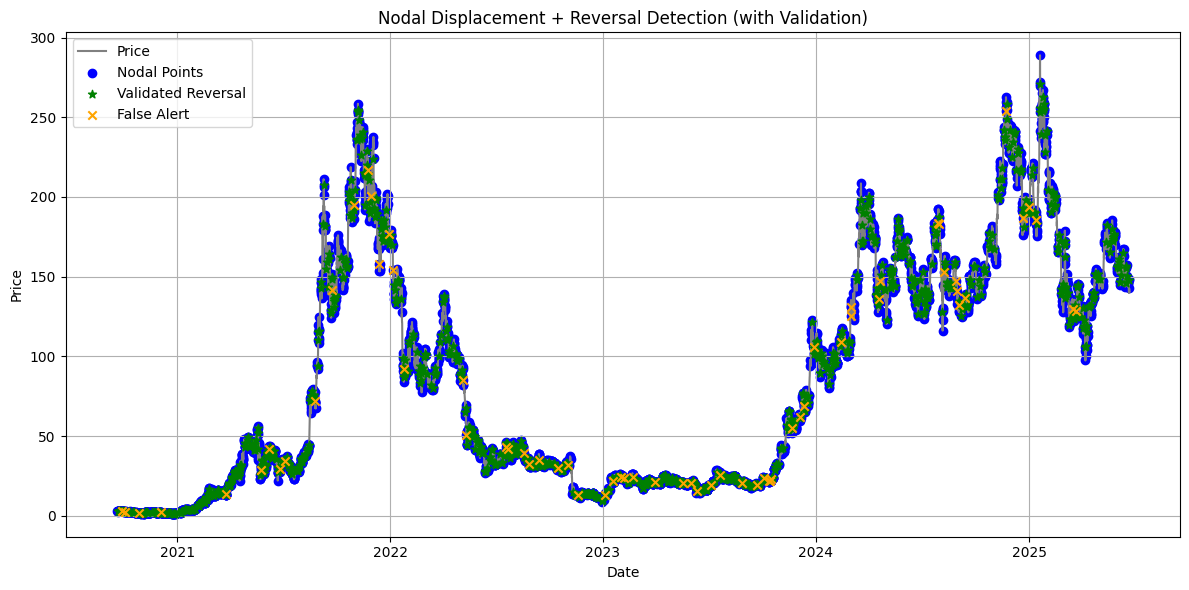


Total Alerts: 1173
Validated Reversals: 1106
False Alerts: 67


In [ ]:

def validate_reversals(prices, alerts, window=3):
    """
    Validates reversal alerts by checking if the price indeed reverses
    within a few bars after the alert.

    Args:
        prices (np.ndarray): Series of price values (e.g., closes)
        alerts (list): Indices where reversal alerts were triggered
        window (int): Number of bars after the alert to check for a confirmed reversal

    Returns:
        validated_alerts (list): Indices from `alerts` that were validated as reversals
        false_alerts (list): Indices from `alerts` that did not lead to a reversal
    """
    validated_alerts = []
    false_alerts = []

    for alert_idx in alerts:
        # Ensure we don't go out of bounds when checking the window
        check_start_idx = alert_idx
        check_end_idx = min(alert_idx + window, len(prices) - 1)

        if check_start_idx >= check_end_idx:
             # Not enough data points after the alert to check
             false_alerts.append(alert_idx)
             continue

        alert_price = prices[alert_idx]

        # Determine the expected direction of the reversal
        # We assume an alert is triggered when the current displacement is smaller than the previous one,
        # indicating potential exhaustion of the *current* trend segment.
        # To determine the previous displacement direction, we need to look at the node history.
        # This is a simplified validation. A more robust approach would link alerts back to
        # the specific nodal sequence that triggered them.
        # For simplicity here, let's check if the price movement within the window
        # is opposite to the trend just before the alert.

        # Determine the trend direction just before the alert (simplified by comparing alert_price to window bars before)
        if alert_idx >= window:
            price_before_window = prices[alert_idx - window]
            # Check if the price moved significantly in the opposite direction within the window after the alert
            if alert_price > price_before_window: # Was likely in an uptrend before alert
                # Check for a drop after the alert
                if any(prices[i] < alert_price for i in range(check_start_idx + 1, check_end_idx + 1)):
                     validated_alerts.append(alert_idx)
                else:
                     false_alerts.append(alert_idx)
            elif alert_price < price_before_window: # Was likely in a downtrend before alert
                # Check for a rise after the alert
                 if any(prices[i] > alert_price for i in range(check_start_idx + 1, check_end_idx + 1)):
                     validated_alerts.append(alert_idx)
                 else:
                     false_alerts.append(alert_idx)
            else: # Price was flat before the alert, difficult to validate reversal
                false_alerts.append(alert_idx)
        else: # Not enough data before the alert to determine prior trend
             false_alerts.append(alert_idx)


    return validated_alerts, false_alerts

# --- Step 4: Validate Alerts ---
validated_alerts, false_alerts = validate_reversals(prices, alerts, window=cycle_window)

# --- Step 5: Plot results with validation ---
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label="Price", color="gray")
plt.scatter(dates[nodes], prices[nodes], color="blue", label="Nodal Points")
plt.scatter(dates[validated_alerts], prices[validated_alerts], color="green", label="Validated Reversal", zorder=5, marker='*')
plt.scatter(dates[false_alerts], prices[false_alerts], color="orange", label="False Alert", zorder=5, marker='x')

plt.title("Nodal Displacement + Reversal Detection (with Validation)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nTotal Alerts: {len(alerts)}")
print(f"Validated Reversals: {len(validated_alerts)}")
print(f"False Alerts: {len(false_alerts)}")

## Recursive Market Prediction


Composite Displacement Check:

If net displacement(sum of rallies - sum of corrections) becomes significantly negative (in an uptrend), it signals reversal momentum.


In [ ]:
def predict_market_price(
    prices,
    rallies,
    corrections,
    alphas,
    window=2,
    max_gain_cap=2.5,
    decay=0.95,
    start_from=0,
    min_gain=0.01,
    max_gain=0.5,
    reversal_lead_factor=1.5
):
    """
    Predicts market price and timing using multiple alpha values and net rally movements.

    Args:
        prices (np.array): Time series of prices
        rallies (list): Indices of rally starts
        corrections (list): Indices of correction ends
        alphas (list): Alpha values per cycle
        window (int): Offset window
        max_gain_cap (float): Max price multiplier cap
        decay (float): Time decay weight
        start_from (int): Index to start looping from
        min_gain (float): Minimum % move to accept
        max_gain (float): Maximum % move to accept
        reversal_lead_factor (float): Scale for projecting timing

    Returns:
        tuple: (predicted_price, predicted_time_idx)
    """
    prices = np.asarray(prices)
    start_idx = rallies[-1] - window + 1
    start_price = prices[start_idx]

    pct_rallies = []
    time_deltas = []
    selected_alphas = []

    for i in range(start_from, min(len(rallies), len(corrections), len(alphas))):
        try:
            p_start = prices[rallies[i] - window + 1]
            p_end = prices[corrections[i]]
            pct_change = (p_end - p_start) / p_start
            if min_gain < pct_change < max_gain:
                pct_rallies.append(pct_change)
                time_deltas.append(corrections[i] - rallies[i])
                selected_alphas.append(alphas[i])
        except IndexError:
            continue

    if not pct_rallies:
        print("⚠️ No valid rallies found after filtering.")
        return start_price, None

    weights = np.array([decay**i for i in range(len(pct_rallies))])
    net_movements = np.array(pct_rallies)

    # Weighted alpha mean
    weighted_alpha_mean = np.average(selected_alphas, weights=net_movements)
    net_gain_factor = 1 - weighted_alpha_mean

    weighted_avg_gain = np.dot(pct_rallies, weights) / np.sum(weights)
    avg_duration = np.dot(time_deltas, weights) / np.sum(weights)

    predicted_price = start_price * (1 + net_gain_factor * weighted_avg_gain * len(pct_rallies))
    predicted_price = min(predicted_price, start_price * max_gain_cap)

    predicted_time_idx = int(rallies[-1] + reversal_lead_factor * avg_duration)

    return round(predicted_price, 4), predicted_time_idx


In [ ]:
weighted_alpha_mean = np.average(alphas, weights=net_movements)

print("Weighted Mean Alpha:", weighted_alpha_mean)

Weighted Mean Alpha: 0.7462762487202075


In [ ]:
window_pred = 1
# predicted = predict_market_price(prices, rallies, corrections, alpha=weighted_alpha_mean, window=window_pred)
predicted_price, predicted_time = predict_market_price(
    prices=prices,
    rallies=rallies,
    corrections=corrections,
    alphas=alphas,
    start_from=10,
    window=window_pred,
    reversal_lead_factor=1.5,
)

print(f"📈 Predicted Price at End of Composite Cycle {window_pred}={predicted_time}:", predicted_price)
# f"| 1 Composite Cycle is {len(net_movements)} net movements"

📈 Predicted Price at End of Composite Cycle 1=16139: 400.225


In [ ]:
def plot_prediction(prices, predicted_price, predicted_time_idx, start_idx):
    plt.figure(figsize=(12, 4))
    plt.plot(prices, label="Actual Price", color='blue')
    plt.axvline(start_idx, color='gray', linestyle='--', label="Start Point")
    plt.axhline(predicted_price, color='green', linestyle='--', label=f"Predicted Price")
    if predicted_time_idx is not None and predicted_time_idx < len(prices):
        plt.axvline(predicted_time_idx, color='red', linestyle='--', label="Predicted Reversal Time")
    plt.title("Price & Reversal Time Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


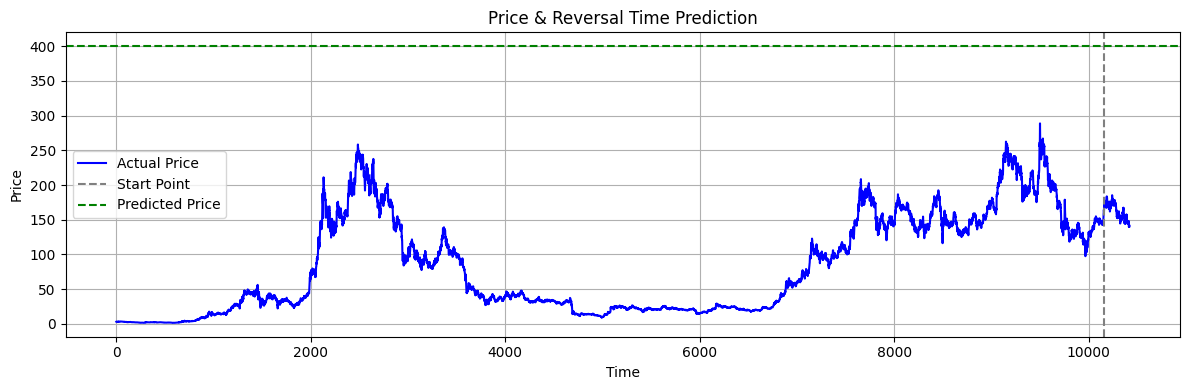

In [ ]:
plot_prediction(prices, predicted_price, predicted_time, rallies[-1] - 2 + 1)


## 🔬 Advanced: Predict α per cycle

You could even go further and:

* **Predict α** using a regression model on:

  * volatility
  * cycle duration
  * volume
  * session/time of day

This would let you **forecast future α**, not just use a trailing average.



In [ ]:
# @title Step 1: Feature Extraction Function

def extract_cycle_features(rallies, corrections, closes, highs, lows, volumes, slopes, window):
    """
    Extracts features for predicting the alpha (correction factor) of market cycles.

    Args:
        rallies (list): List of indices where rallies end.
        corrections (list): List of indices where corrections end.
        closes (np.ndarray): Array of closing prices.
        highs (np.ndarray): Array of high prices.
        lows (np.ndarray): Array of low prices.
        volumes (np.ndarray): Array of trading volumes.
        slopes (list): List of computed slopes for price segments.
        window (int): The window size used for detecting cycles.

    Returns:
        tuple: A tuple containing two numpy arrays:
               - features_scaled (np.ndarray): An array of normalized features
                                        (volume sum, duration, slope, price range, volatility)
                                        for a detected cycle.
               - alphas (np.ndarray): An array of the calculated alpha values for each
                                      corresponding cycle.
               - scaler (MinMaxScaler): The fitted scaler object to inverse transform predictions if needed.
    """
    features = []
    alphas = []

    for r_idx in rallies:
        try:
            # Find the next correction after the rally
            c_idx = next(c for c in corrections if c > r_idx)
            rally_start = r_idx - window + 1
            rally_end = r_idx
            correction_end = c_idx

            # Calculate Rally (R) and Correction (K) magnitudes
            R = closes[rally_end] - closes[rally_start]
            K = closes[correction_end] - closes[rally_end]
            # Calculate alpha (Correction Factor)
            alpha = abs(K) / R if R != 0 else 0
            # alpha = min(abs(K) / R, 1) if R != 0 else 0

            # Extract features for the cycle
            duration = correction_end - rally_start
            # Get the slope corresponding to the start of the rally detection window
            slope = slopes[r_idx - window] if (r_idx - window) < len(slopes) else 0
            # Sum of volume during the cycle
            vol_sum = np.sum(volumes[rally_start:correction_end + 1])
            # Price range (High - Low) during the cycle
            range_ = np.max(highs[rally_start:correction_end + 1]) - np.min(lows[rally_start:correction_end + 1])
            # Calculate returns and volatility during the cycle
            returns = np.diff(closes[rally_start:correction_end + 1])
            volatility = np.std(returns)

            # # Nodal displacement: ΔP between last two nodal points before correction_end
            # if len(nodal_points) >= window:
            #   prior_nodals = [n for n in nodal_points if n <= correction_end]
            #   if len(prior_nodals) >= 2:
            #       delta_P = closes[prior_nodals[-1]] - closes[prior_nodals[-2]]
            #   else:
            #       delta_P = 0.0
            # else:
            #   delta_P = 0.0

            # features.append([vol_sum, duration, slope, range_, volatility, delta_P])

            # Append the extracted features and the calculated alpha
            features.append([vol_sum, duration, slope, range_, volatility])
            alphas.append(alpha)
        except:
            # Skip if there's an error (e.g., no correction found after a rally)
            continue

    if not features:
      return np.array([]), np.array([]), None

    features_np = np.array(features)
    alphas_np = np.array(alphas).reshape(-1, 1) # Reshape for scaler

    # Normalize the features
    feature_scaler = MinMaxScaler()
    features_scaled = feature_scaler.fit_transform(features_np)

    # Normalize the alpha values
    alpha_scaler = MinMaxScaler()
    alphas_scaled = alpha_scaler.fit_transform(alphas_np)

    out = {
        'features': features_np,
        'alphas': alphas_np,
        'features_scaled': features_scaled,
        'alphas_scaled': alphas_scaled,
        'feature_scaler': feature_scaler,
        'alpha_scaler': alpha_scaler
    }

    return out


In [ ]:
len(displacements) # predict the next displacement?

5233

In [ ]:
out = extract_cycle_features(rallies, corrections, closes, highs, lows, volumes, slopes, window=3)
out

{'features': array([[ 1.18884437e+06,  1.05000000e+02,  6.12028571e-02,
          5.95500000e+00,  2.68643071e-01],
        [ 1.16852676e+06,  1.04000000e+02,  3.82571429e-03,
          5.89730000e+00,  2.69408097e-01],
        [ 1.15778012e+06,  1.03000000e+02, -3.33885714e-02,
          5.81760000e+00,  2.70681304e-01],
        [ 1.05690702e+06,  9.10000000e+01,  8.44571429e-02,
          5.43950000e+00,  2.81956713e-01],
        [ 8.61343960e+05,  7.40000000e+01,  4.57685714e-02,
          4.20790000e+00,  2.97227974e-01],
        [ 1.88136180e+05,  2.10000000e+01, -4.73828571e-02,
          2.82200000e+00,  4.76329389e-01],
        [ 2.60333661e+07,  8.04000000e+02, -1.29300000e-01,
          4.62149000e+01,  1.35923177e+00],
        [ 2.57513516e+07,  7.74000000e+02,  2.09745714e-01,
          4.35784000e+01,  1.38225073e+00],
        [ 2.53003455e+07,  7.34000000e+02,  4.79594286e-01,
          3.92267000e+01,  1.41508559e+00],
        [ 2.52899390e+07,  7.33000000e+02,  3.746485

In [ ]:
# Get scaled data and scalers
X, y, X_scaled, y_scaled, feature_scaler, alpha_scaler = out['features'], out['alphas'], out['features_scaled'], out['alphas_scaled'], out['feature_scaler'], out['alpha_scaler']

X.shape, y.shape

((111, 5), (111, 1))

In [ ]:
# @title Step 2: Train Alpha Regressor

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


def train_alpha_model(X, y):
    model = LinearRegression()
    # model = RandomForestRegressor(n_estimators=20, random_state=42)
    model.fit(X, y)
    return model


def train_alpha_model_nn(X, y):
  model = Sequential()

  # Adding LSTM layers
  model.add(LSTM(units=8, return_sequences=True, input_shape=(X.shape[1], 1)))
  model.add(LSTM(units=8, return_sequences=True))
  model.add(LSTM(units=8, return_sequences=False))  # Only the last time step

  # Adding a Dense layer to match the output shape with y
  model.add(Dense(1))

  # Compiling the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Training the model
  history = model.fit(X, y, epochs=100, batch_size=25, validation_split=0.2)
  return model, history


In [ ]:
# Train your model on plain and scaled data
# model_plain = train_alpha_model(X, y)
model = train_alpha_model(X_scaled, y)
# model, history = train_alpha_model_nn(X_scaled, y)

model

LinearRegression()

In [ ]:
# @title Step 3: Predict Alpha for New Features

def predict_alpha(model, feature_scaler, alpha_scaler, features_dict: dict):
    """
    Predicts alpha for new features using a trained model and scalers.

    Args:
        model: The trained regression model.
        feature_scaler: The scaler used for normalizing features.
        alpha_scaler: The scaler used for normalizing alpha.
        features_dict (dict): A dictionary containing the new cycle features
                              (vol_sum, duration, slope, range_, volatility).

    Returns:
        float: The predicted alpha in the original scale.
    """
    # Ensure the order of features matches the scaler's training order
    ordered_features = np.array([[
        features_dict['vol_sum'],
        features_dict['duration'],
        features_dict['slope'],
        features_dict['range_'],
        features_dict['volatility']
    ]])

    # Prepare and scale new features
    new_features_scaled = feature_scaler.transform(ordered_features)

    # Predict scaled alpha
    predicted_alpha_scaled = model.predict(new_features_scaled)

    # Inverse transform the predicted scaled alpha to get the original alpha value
    predicted_alpha_original_scale = alpha_scaler.inverse_transform(predicted_alpha_scaled.reshape(-1, 1))

    # The inverse_transform returns an array, so access the first element
    predicted_alpha = predicted_alpha_original_scale[0][0]

    return predicted_alpha


In [ ]:
# Assuming you have already run the `extract_cycle_features` function to get the features X
# And you have already fit the `LinearRegression` model on X and y (alpha_targets)
# You can get the last known values from the X array.

if len(X) > 0:
  last_cycle_features_dict = {
      'vol_sum': X[-1][0],
      'duration': X[-1][1],
      'slope': X[-1][2],
      'range_': X[-1][3],
      'volatility': X[-1][4]
  }
  # Check if the model was successfully trained (if X was not empty)
  if 'model' in locals() and hasattr(model, 'predict'):
    # Pass the features dictionary and the scalers to the predict_alpha function
    pred_alpha = predict_alpha(model, feature_scaler, alpha_scaler, last_cycle_features_dict)
    pred_alpha_scaled = alpha_scaler.transform(np.array([pred_alpha]).reshape(-1, 1))
    pred_alpha_scaled = pred_alpha_scaled[0][0]
    print("📈 Predicted Alpha for the last known cycle:", pred_alpha_scaled)
  else:
    print("Model was not trained because no cycles were detected or feature extraction failed.")
else:
  print("No cycles detected to extract features for prediction.")


📈 Predicted Alpha for the last known cycle: 5.1048610906700125


In [ ]:
# predicted_price, predicted_time = predict_market_price(prices, rallies, corrections, alphas=alphas[:10]+[pred_alpha_scaled], start_from=10, window=1)
# print(f"📈 Predicted Price at Composite {predicted_time} Cycle End:", predicted_price)

## Trade Signals

In [ ]:
def generate_full_trade_signals(df, structures, ob_zones=None, fvg_zones=None, buffer_pct=0.005, risk_multiplier=2):
    """
    Generates enriched trade signals with SL, TP1 (2R), confluence and type labels.

    Args:
        df (pd.DataFrame): OHLCV dataframe
        structures (list): Output from detect_nodal_displacements
        ob_zones (list of dict): [{'type': 'Bullish OB', 'y0': float, 'y1': float, 'start_idx': int}]
        fvg_zones (list of dict): Same format for FVG
        buffer_pct (float): SL buffer as % of entry

    Returns:
        pd.DataFrame
    """
    import pandas as pd

    signals = []

    for s in structures:
        if s['type'] not in ('BOS', 'CHoCH'):
            continue

        idx = s['index']
        time = df.index[idx]
        level = s['broken_level']
        trend = s['trend']
        mitigated = s.get('mitigated', False)

        if s['type'] == 'BOS':
            direction = 'long' if trend == 'bullish' else 'short'
            entry = level
            sl = entry * (1 - buffer_pct) if direction == 'long' else entry * (1 + buffer_pct)
            signal_type = f"BOS {direction.title()}"
        else:  # CHoCH
            direction = 'short' if trend == 'bearish' else 'long'
            entry = level
            sl = entry * (1 + buffer_pct) if direction == 'short' else entry * (1 - buffer_pct)
            signal_type = f"CHoCH {direction.title()}"

        # TP1 as 2R
        risk = abs(entry - sl)
        tp1 = entry + risk_multiplier * risk if direction == 'long' else entry - risk_multiplier * risk

        # Check confluence
        confluences = []
        if ob_zones:
            for ob in ob_zones:
                if direction == 'long' and ob['type'] == 'Bullish OB' and ob['y0'] <= entry <= ob['y1']:
                    confluences.append('OB')
                elif direction == 'short' and ob['type'] == 'Bearish OB' and ob['y0'] <= entry <= ob['y1']:
                    confluences.append('OB')

        if fvg_zones:
            for fvg in fvg_zones:
                if direction == 'long' and fvg['type'] == 'Bullish FVG' and fvg['y0'] <= entry <= fvg['y1']:
                    confluences.append('FVG')
                elif direction == 'short' and fvg['type'] == 'Bearish FVG' and fvg['y0'] <= entry <= fvg['y1']:
                    confluences.append('FVG')

        confluences = '+'.join([s['type']] + confluences) if confluences else s['type']

        signals.append({
            'time': time,
            'signal_type': signal_type,
            'direction': direction,
            'entry_price': round(entry, 4),
            'sl_price': round(sl, 4),
            'tp1_price': round(tp1, 4),
            'structure_type': s['type'],
            'confluence': confluences,
            'structure_idx': idx,
            'mitigated': mitigated
        })

    return pd.DataFrame(signals)


structure_signals_df = generate_full_trade_signals(
    df=ohlcv,
    structures=structures,
    # ob_zones=your_ob_list,
    # fvg_zones=your_fvg_list,
    buffer_pct=0.005,
    risk_multiplier=3,
)
structure_signals_df

,time,signal_type,direction,entry_price,sl_price,tp1_price,structure_type,confluence,structure_idx,mitigated
0,17,CHoCH Short,short,3.0116,3.0267,2.9664,CHoCH,CHoCH,17,False
1,18,BOS Short,short,2.5312,2.5439,2.4932,BOS,BOS,18,True
2,22,CHoCH Long,long,2.7407,2.7270,2.7818,CHoCH,CHoCH,22,False
3,24,BOS Long,long,2.9652,2.9504,3.0097,BOS,BOS,24,True
4,27,BOS Long,long,2.9875,2.9726,3.0323,BOS,BOS,27,True
...,...,...,...,...,...,...,...,...,...,...
3041,10391,BOS Long,long,157.6200,156.8319,159.9843,BOS,BOS,10391,True
3042,10404,CHoCH Short,short,157.6500,158.4382,155.2853,CHoCH,CHoCH,10404,False
3043,10407,BOS Short,short,145.0000,145.7250,142.8250,BOS,BOS,10407,True
3044,10412,CHoCH Long,long,144.9200,144.1954,147.0938,CHoCH,CHoCH,10412,False


In [ ]:
def generate_signals_from_ob_fvg(df, ob_zones, fvg_zones, buffer_pct=0.005, risk_multiplier=2):
    """
    Generate trade signals from OB and FVG DataFrames.

    Args:
        df (pd.DataFrame): OHLCV DataFrame with datetime index
        ob_zones (pd.DataFrame): Order block zones
        fvg_zones (pd.DataFrame): FVG zones
        buffer_pct (float): SL buffer as percent

    Returns:
        pd.DataFrame: Trade signals with entry, SL, TP1, TP2, confluence
    """
    import pandas as pd

    signals = []

    # Combine into one DataFrame for confluence detection
    all_zones = pd.concat([ob_zones, fvg_zones], ignore_index=True)

    for i, zone in all_zones.iterrows():
        zone_type = zone['type']
        y0, y1 = zone['y0'], zone['y1']
        start_idx = zone['start_idx']
        time = df.index[start_idx]
        entry_price = (y0 + y1) / 2

        # Direction
        if 'Bullish' in zone_type:
            direction = 'long'
            sl_price = y0 * (1 - buffer_pct)
        elif 'Bearish' in zone_type:
            direction = 'short'
            sl_price = y1 * (1 + buffer_pct)
        else:
            continue

        # Risk and TP1
        risk = abs(entry_price - sl_price)
        tp1_price = entry_price + risk_multiplier * risk if direction == 'long' else entry_price - risk_multiplier * risk

        # TP2: next opposing zone (optional)
        tp2_price = None
        if direction == 'long':
            opposing = all_zones[(all_zones['type'].str.contains('Bearish')) & (all_zones['y0'] > entry_price)]
            if not opposing.empty:
                tp2_price = opposing['y0'].min()
        else:
            opposing = all_zones[(all_zones['type'].str.contains('Bullish')) & (all_zones['y1'] < entry_price)]
            if not opposing.empty:
                tp2_price = opposing['y1'].max()

        # Confluence (other overlapping zones)
        overlaps = all_zones[(all_zones.index != i) &
                             (all_zones['y0'] <= entry_price) &
                             (all_zones['y1'] >= entry_price)]
        overlapping_types = overlaps['type'].tolist()
        confluence = zone_type + ("+" + "+".join(overlapping_types) if overlapping_types else "")

        signals.append({
            'time': time,
            'signal_type': f"{zone_type} Entry",
            'direction': direction,
            'entry_price': round(entry_price, 4),
            'sl_price': round(sl_price, 4),
            'tp1_price': round(tp1_price, 4),
            'tp2_price': round(tp2_price, 4) if tp2_price else None,
            'structure_type': zone_type,
            'confluence': confluence,
            'structure_idx': start_idx,
            'mitigated': zone.get('mitigated', False)
        })

    return pd.DataFrame(signals)

ob_fvg_signals_df = generate_signals_from_ob_fvg(
    df=ohlcv,
    ob_zones=ob_df,
    fvg_zones=fvg_df,
    buffer_pct=0.005,
    risk_multiplier=3,
)
ob_fvg_signals_df

,time,signal_type,direction,entry_price,sl_price,tp1_price,tp2_price,structure_type,confluence,structure_idx,mitigated
0,3,Bearish OB Entry,short,3.1688,3.2592,2.8976,3.1483,Bearish OB,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...,3,False
1,9,Bullish OB Entry,long,2.9471,2.8776,3.1555,2.9510,Bullish OB,Bullish OB+Bearish OB+Bearish OB+Bullish OB+Be...,9,False
2,10,Bearish OB Entry,short,2.9169,2.9433,2.8378,2.9094,Bearish OB,Bearish OB+Bullish OB+Bearish OB+Bullish OB+Be...,10,False
3,13,Bullish OB Entry,long,2.7823,2.7440,2.8970,2.8067,Bullish OB,Bullish OB+Bullish OB+Bearish OB+Bullish OB+Bu...,13,False
4,15,Bearish OB Entry,short,2.9676,3.0267,2.7904,2.9652,Bearish OB,Bearish OB+Bullish OB+Bearish OB+Bullish OB+Be...,15,False
...,...,...,...,...,...,...,...,...,...,...,...
7371,10395,Bearish FVG Entry,short,151.9250,153.2424,147.9728,151.9100,Bearish FVG,Bearish FVG+Bullish OB+Bullish OB+Bullish OB+B...,10395,False
7372,10396,Bearish FVG Entry,short,150.2800,151.1620,147.6339,150.2200,Bearish FVG,Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...,10396,False
7373,10401,Bearish FVG Entry,short,146.6150,147.3833,144.3103,146.5800,Bearish FVG,Bearish FVG+Bearish OB+Bearish OB+Bullish OB+B...,10401,False
7374,10414,Bearish FVG Entry,short,145.0400,147.7953,136.7741,145.0000,Bearish FVG,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,10414,False


In [ ]:
def combine_signal_tables(structure_signals_df, ob_fvg_signals_df):
    """
    Combine BOS/CHoCH signals with OB/FVG signals into one unified signal table.

    Args:
        structure_signals_df (pd.DataFrame): Output from generate_full_trade_signals()
        ob_fvg_signals_df (pd.DataFrame): Output from generate_signals_from_ob_fvg()

    Returns:
        pd.DataFrame: Combined and sorted signal table
    """
    # Align column sets
    all_columns = set(structure_signals_df.columns).union(set(ob_fvg_signals_df.columns))
    structure_signals_df = structure_signals_df.reindex(columns=all_columns)
    ob_fvg_signals_df = ob_fvg_signals_df.reindex(columns=all_columns)

    combined_df = pd.concat([structure_signals_df, ob_fvg_signals_df], ignore_index=True)
    combined_df.sort_values(by='time', inplace=True)
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

combined_signals = combine_signal_tables(structure_signals_df, ob_fvg_signals_df)
combined_signals

,direction,time,structure_type,signal_type,confluence,entry_price,tp2_price,mitigated,sl_price,structure_idx,tp1_price
0,short,3,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...,3.1688,3.1483,False,3.2592,3,2.8976
1,short,4,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...,3.0896,3.0641,False,3.1101,4,3.0280
2,short,7,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bullish OB+B...,3.0028,3.0021,False,3.0227,7,2.9430
3,short,8,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,3.0115,3.0072,False,3.0360,8,2.9380
4,short,9,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bullish OB+Bearish OB+Bearish OB+B...,2.9515,2.9409,False,2.9891,9,2.8386
...,...,...,...,...,...,...,...,...,...,...,...
10417,short,10413,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bullish OB+Bu...,147.8850,147.8746,False,149.4535,10413,143.1794
10418,long,10413,BOS,BOS Long,BOS,147.6900,NaN,True,146.9516,10413,149.9054
10419,short,10414,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,145.0400,145.0000,False,147.7953,10414,136.7741
10420,short,10415,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,142.2350,142.1900,False,143.3029,10415,139.0312


## Backtest

In [ ]:
import pandas as pd
import numpy as np

symbols = ["BTC-USD", "ETH-USD", "LTC-USD"]
price = vbt.YFData.download(symbols, missing_index='drop').get('Close')

windows = np.arange(2, 101)
fast_ma, slow_ma = vbt.MA.run_combs(
    price,
    window=windows,
    r=2,
    short_names=['fast', 'slow']
)
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(
    price,
    entries,
    exits,
    size=np.inf,
    fees=0.001,
    freq='1D'
)

fig = pf.total_return().vbt.heatmap(
    x_level='fast_window',
    y_level='slow_window',
    slider_level='symbol',
    symmetric=True,
    trace_kwargs=dict(
        colorbar=dict(
            title='Total return',
            tickformat='%'
        )
    )
)
fig.show()

In [ ]:
def backtest_signals(df, signal_df, hold_until_tp2=False):
    """
    Simulate signal outcomes by checking if SL, TP1, or TP2 was hit first.

    Args:
        df (pd.DataFrame): OHLCV data
        signal_df (pd.DataFrame): Signal table
        hold_until_tp2 (bool): If True, hold for TP2 instead of exiting at TP1

    Returns:
        pd.DataFrame: Updated signal_df with 'outcome' and 'rr' (reward-risk)
    """
    outcomes = []
    rrs = []

    for _, row in signal_df.iterrows():
        idx = row['structure_idx']
        entry = row['entry_price']
        sl = row['sl_price']
        tp1 = row['tp1_price']
        tp2 = row.get('tp2_price', None)
        direction = row['direction']
        risk = abs(entry - sl)

        hit = None
        rr = 0

        future_df = df.iloc[idx+1:]

        for t, bar in future_df.iterrows():
            if direction == 'long':
                if bar['low'] <= sl:
                    hit = 'SL'
                    rr = -1
                    break
                if bar['high'] >= tp2 if hold_until_tp2 and pd.notna(tp2) else bar['high'] >= tp1:
                    hit = 'TP2' if hold_until_tp2 and pd.notna(tp2) else 'TP1'
                    rr = 2 if hit == 'TP1' else (tp2 - entry) / risk
                    break
            else:
                if bar['high'] >= sl:
                    hit = 'SL'
                    rr = -1
                    break
                if bar['low'] <= tp2 if hold_until_tp2 and pd.notna(tp2) else bar['low'] <= tp1:
                    hit = 'TP2' if hold_until_tp2 and pd.notna(tp2) else 'TP1'
                    rr = 2 if hit == 'TP1' else (entry - tp2) / risk
                    break

        if hit is None:
            hit = 'Open'
            rr = 0

        outcomes.append(hit)
        rrs.append(round(rr, 2))

    signal_df['outcome'] = outcomes
    signal_df['rr'] = rrs
    return signal_df


In [ ]:
# Simulate trades assuming TP1 as exit
backtest_results = backtest_signals(ohlcv, combined_signals, hold_until_tp2=False)
backtest_results[['time', 'signal_type', 'outcome', 'rr']]

,time,signal_type,outcome,rr
0,3,Bearish OB Entry,TP1,2
1,4,Bearish FVG Entry,TP1,2
2,7,Bearish FVG Entry,TP1,2
3,8,Bearish FVG Entry,TP1,2
4,9,Bearish FVG Entry,TP1,2
...,...,...,...,...
10417,10413,Bearish OB Entry,TP1,2
10418,10413,BOS Long,SL,-1
10419,10414,Bearish FVG Entry,TP1,2
10420,10415,Bearish FVG Entry,TP1,2


In [ ]:
# Optionally: simulate TP2 targeting
backtest_tp2 = backtest_signals(ohlcv, combined_signals.copy(), hold_until_tp2=True)
backtest_tp2

,direction,time,structure_type,signal_type,confluence,entry_price,tp2_price,mitigated,sl_price,structure_idx,tp1_price,outcome,rr
0,short,3,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...,3.1688,3.1483,False,3.2592,3,2.8976,TP2,0.23
1,short,4,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...,3.0896,3.0641,False,3.1101,4,3.0280,TP2,1.24
2,short,7,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bullish OB+B...,3.0028,3.0021,False,3.0227,7,2.9430,TP2,0.04
3,short,8,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,3.0115,3.0072,False,3.0360,8,2.9380,TP2,0.18
4,short,9,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bullish OB+Bearish OB+Bearish OB+B...,2.9515,2.9409,False,2.9891,9,2.8386,TP2,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,short,10413,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bullish OB+Bu...,147.8850,147.8746,False,149.4535,10413,143.1794,TP2,0.01
10418,long,10413,BOS,BOS Long,BOS,147.6900,NaN,True,146.9516,10413,149.9054,SL,-1.00
10419,short,10414,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,145.0400,145.0000,False,147.7953,10414,136.7741,TP2,0.01
10420,short,10415,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,142.2350,142.1900,False,143.3029,10415,139.0312,TP2,0.04


In [ ]:
backtest_tp2[backtest_tp2['outcome'].isin(['SL'])]

,direction,time,structure_type,signal_type,confluence,entry_price,tp2_price,mitigated,sl_price,structure_idx,tp1_price,outcome,rr
6,short,10,Bearish OB,Bearish OB Entry,Bearish OB+Bullish OB+Bearish OB+Bullish OB+Be...,2.9169,2.9094,False,2.9433,10,2.8378,SL,-1.0
9,short,13,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bullish OB+Bullish OB+Bearish OB+B...,2.7938,2.6593,False,2.8277,13,2.6922,SL,-1.0
18,short,18,BOS,BOS Short,BOS,2.5312,NaN,True,2.5439,18,2.4932,SL,-1.0
24,long,24,BOS,BOS Long,BOS,2.9652,NaN,True,2.9504,24,3.0097,SL,-1.0
27,long,27,BOS,BOS Long,BOS,2.9875,NaN,True,2.9726,27,3.0323,SL,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10411,short,10407,BOS,BOS Short,BOS,145.0000,NaN,True,145.7250,10407,142.8250,SL,-1.0
10412,long,10407,Bullish OB,Bullish OB Entry,Bullish OB+Bearish OB+Bearish OB+Bearish OB+Bu...,145.7000,145.7981,False,144.1954,10407,150.2138,SL,-1.0
10414,long,10411,Bullish OB,Bullish OB Entry,Bullish OB+Bearish OB+Bearish OB+Bullish OB+Bu...,146.6050,146.6600,False,144.9814,10411,151.4757,SL,-1.0
10415,short,10412,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Bu...,146.2700,146.2400,False,148.4284,10412,139.7947,SL,-1.0


In [ ]:
# expectancy = (P_win * avg_win) - (P_loss * avg_loss)
# Example:
grouped = backtest_results.groupby(['structure_type', 'confluence'])['outcome'].value_counts(normalize=True).unstack().fillna(0)
print(grouped[['TP1', 'SL']]) #  'TP2'

outcome                                                                 TP1  \
structure_type confluence                                                     
BOS            BOS                                                 0.141975   
Bearish FVG    Bearish FVG+Bearish OB+Bearish OB+Bearish FVG+B...  0.000000   
               Bearish FVG+Bearish OB+Bearish OB+Bearish OB+Be...  1.000000   
               Bearish FVG+Bearish OB+Bearish OB+Bearish OB+Be...  1.000000   
               Bearish FVG+Bearish OB+Bearish OB+Bearish OB+Be...  1.000000   
...                                                                     ...   
Bullish OB     Bullish OB+Bullish OB+Bullish OB+Bullish OB+Bul...  0.000000   
               Bullish OB+Bullish OB+Bullish OB+Bullish OB+Bul...  0.000000   
               Bullish OB+Bullish OB+Bullish OB+Bullish OB+Bul...  1.000000   
               Bullish OB+Bullish OB+Bullish OB+Bullish OB+Bul...  0.000000   
CHoCH          CHoCH                                

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def build_logistic_win_model(signal_df):
    """
    Train a logistic regression model to estimate probability of a trade winning (TP1/TP2).

    Args:
        signal_df (pd.DataFrame): Signal data with outcomes and features

    Returns:
        model: Trained pipeline with preprocessor and logistic regression
        feature_names: List of feature column names used
    """
    # Define binary target: 1 for win, 0 for loss
    df = signal_df.copy()
    df = df[df['outcome'].isin(['TP1', 'TP2', 'SL'])]
    df['win'] = df['outcome'].isin(['TP1', 'TP2']).astype(int)

    # Features to use (adjustable)
    df['confluence_count'] = df['confluence'].str.count('\+') + 1
    df['mitigated'] = df['mitigated'].astype(int)

    features = ['structure_type', 'confluence_count', 'mitigated']
    X = df[features]
    y = df['win']

    # One-hot encode categorical features
    categorical_features = ['structure_type']
    numeric_features = ['confluence_count', 'mitigated']

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear'))
    ])

    # Fit the model
    model = pipeline.fit(X, y)

    return model, features


model, features = build_logistic_win_model(combined_signals)

# Predict probabilities
combined_signals['confluence_count'] = combined_signals['confluence'].str.count('\+') + 1
X_new = combined_signals[features]
combined_signals['win_probability'] = model.predict_proba(X_new)[:, 1]
combined_signals

,direction,time,structure_type,signal_type,confluence,entry_price,tp2_price,mitigated,sl_price,structure_idx,tp1_price,outcome,rr,confluence_count,win_probability
0,short,3,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...,3.1688,3.1483,False,3.2592,3,2.8976,TP1,2,13,0.397280
1,short,4,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...,3.0896,3.0641,False,3.1101,4,3.0280,TP1,2,18,0.813467
2,short,7,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bullish OB+B...,3.0028,3.0021,False,3.0227,7,2.9430,TP1,2,19,0.813071
3,short,8,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,3.0115,3.0072,False,3.0360,8,2.9380,TP1,2,18,0.813467
4,short,9,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bullish OB+Bearish OB+Bearish OB+B...,2.9515,2.9409,False,2.9891,9,2.8386,TP1,2,29,0.809079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,short,10413,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bullish OB+Bu...,147.8850,147.8746,False,149.4535,10413,143.1794,TP1,2,152,0.314544
10418,long,10413,BOS,BOS Long,BOS,147.6900,NaN,True,146.9516,10413,149.9054,SL,-1,1,0.132230
10419,short,10414,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,145.0400,145.0000,False,147.7953,10414,136.7741,TP1,2,196,0.732813
10420,short,10415,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,142.2350,142.1900,False,143.3029,10415,139.0312,TP1,2,162,0.749796


### Linear Position Scaling

Risk Mgmt.

In [ ]:
def assign_dynamic_risk(signal_df, win_prob_col='win_probability',
                        base_risk_pct=0.01, scale_factor=0.05,
                        threshold=0.5, min_risk=0.005, max_risk=0.03):
    """
    Add dynamic position size (risk %) based on win probability.

    Args:
        signal_df (pd.DataFrame): Signals with win_probability column
        base_risk_pct (float): Minimum risk size (e.g. 0.01 = 1%)
        scale_factor (float): Risk scale per 1.0 prob delta
        threshold (float): Neutral probability point (e.g. 0.5)
        min_risk (float): Minimum allowed risk size
        max_risk (float): Max allowed risk size

    Returns:
        pd.DataFrame: Updated DataFrame with 'risk_pct' column
    """
    signal_df = signal_df.copy()
    signal_df['risk_pct'] = base_risk_pct + (signal_df[win_prob_col] - threshold) * scale_factor
    signal_df['risk_pct'] = signal_df['risk_pct'].clip(lower=min_risk, upper=max_risk)
    return signal_df


In [ ]:
# After adding win_probability to signals
combined_signals = assign_dynamic_risk(combined_signals)

# Now each signal has a risk percentage
combined_signals[['time', 'direction', 'win_probability', 'risk_pct']].head()


,time,direction,win_probability,risk_pct
0,3,short,0.397280,0.005000
1,4,short,0.813467,0.025673
2,7,short,0.813071,0.025654
3,8,short,0.813467,0.025673
4,9,short,0.809079,0.025454


In [ ]:
def apply_position_sizing_to_backtest(signals_df, capital=100_000, max_risk_pct_col='risk_pct'):
    """
    Simulate backtest PnL using dynamic position sizing based on risk percentage per trade.

    Args:
        signals_df (pd.DataFrame): Must include entry_price, sl_price, tp1_price, outcome, and risk_pct
        capital (float): Starting capital
        max_risk_pct_col (str): Column name that holds per-trade risk percent

    Returns:
        pd.DataFrame: signals_df with PnL, position_size, and equity curve
    """
    df = signals_df.copy()
    equity = capital
    equity_curve = []
    pnl_list = []

    for _, row in df.iterrows():
        entry = row['entry_price']
        sl = row['sl_price']
        tp = row['tp1_price'] if row['outcome'] == 'TP1' else (row['tp2_price'] if row['outcome'] == 'TP2' else sl)
        risk_pct = row[max_risk_pct_col]
        stop_size = abs(entry - sl)

        if stop_size == 0:
            pnl = 0
        else:
            # Risk in $ = capital * risk%
            risk_amount = equity * risk_pct
            # Position size in units
            size = risk_amount / stop_size
            # PnL in $
            pnl = (tp - entry) * size if row['direction'] == 'long' else (entry - tp) * size

        pnl_list.append(pnl)
        equity += pnl
        equity_curve.append(equity)

    df['pnl'] = pnl_list
    df['equity'] = equity_curve
    df['returns'] = df['pnl'] / capital  # normalized return
    return df



In [ ]:
backtest_dynamic = apply_position_sizing_to_backtest(combined_signals, capital=10_000)
backtest_dynamic

,direction,time,structure_type,signal_type,confluence,entry_price,tp2_price,mitigated,sl_price,structure_idx,tp1_price,outcome,rr,confluence_count,win_probability,risk_pct,pnl,equity,returns
0,short,3,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...,3.1688,3.1483,False,3.2592,3,2.8976,TP1,2,13,0.397280,0.005000,1.500000e+02,1.015000e+04,1.500000e-02
1,short,4,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...,3.0896,3.0641,False,3.1101,4,3.0280,TP1,2,18,0.813467,0.025673,7.830248e+02,1.093302e+04,7.830248e-02
2,short,7,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bullish OB+B...,3.0028,3.0021,False,3.0227,7,2.9430,TP1,2,19,0.813071,0.025654,8.428228e+02,1.177585e+04,8.428228e-02
3,short,8,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,3.0115,3.0072,False,3.0360,8,2.9380,TP1,2,18,0.813467,0.025673,9.069765e+02,1.268282e+04,9.069765e-02
4,short,9,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bullish OB+Bearish OB+Bearish OB+B...,2.9515,2.9409,False,2.9891,9,2.8386,TP1,2,29,0.809079,0.025454,9.693430e+02,1.365217e+04,9.693430e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,short,10413,Bearish OB,Bearish OB Entry,Bearish OB+Bearish OB+Bearish OB+Bullish OB+Bu...,147.8850,147.8746,False,149.4535,10413,143.1794,TP1,2,152,0.314544,0.005000,3.881617e+104,2.626506e+106,3.881617e+100
10418,long,10413,BOS,BOS Long,BOS,147.6900,NaN,True,146.9516,10413,149.9054,SL,-1,1,0.132230,0.005000,-1.313253e+104,2.613373e+106,-1.313253e+100
10419,short,10414,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,145.0400,145.0000,False,147.7953,10414,136.7741,TP1,2,196,0.732813,0.021641,1.696652e+105,2.783038e+106,1.696652e+101
10420,short,10415,Bearish FVG,Bearish FVG Entry,Bearish FVG+Bearish OB+Bullish OB+Bearish OB+B...,142.2350,142.1900,False,143.3029,10415,139.0312,TP1,2,162,0.749796,0.022490,1.877757e+105,2.970814e+106,1.877757e+101


In [ ]:
def optimize_scale_factor(signal_df, scale_range=np.arange(0.0, 0.11, 0.01), capital=100_000):
    """
    Optimize scale_factor for dynamic risk sizing to maximize Sharpe Ratio.

    Returns:
        pd.DataFrame: Summary of scale_factor vs Sharpe
        float: Best scale factor
    """
    from scipy.stats import skew
    results = []

    for sf in scale_range:
        test_df = assign_dynamic_risk(signal_df, scale_factor=sf)
        test_df = apply_position_sizing_to_backtest(test_df, capital=capital)

        # Sharpe Ratio (assume daily returns, no compounding)
        returns = test_df['returns']
        if returns.std() == 0:
            sharpe = 0
        else:
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

        results.append({
            'scale_factor': sf,
            'sharpe': round(sharpe, 3),
            'final_equity': test_df['equity'].iloc[-1],
            'max_drawdown': (test_df['equity'].cummax() - test_df['equity']).max()
        })

    results_df = pd.DataFrame(results)
    best_sf = results_df.loc[results_df['sharpe'].idxmax(), 'scale_factor']

    return results_df, best_sf


In [ ]:
results_df, best_sf = optimize_scale_factor(combined_signals)
print(f"📈 Best scale factor: {best_sf}")
results_df.sort_values('sharpe', ascending=False)


📈 Best scale factor: 0.01


,scale_factor,sharpe,final_equity,max_drawdown
1,0.01,0.966,1.696703e+61,5.742601e+59
0,0.00,0.949,3.421866e+47,1.598642e+46
2,0.02,0.928,7.242043e+73,1.734661e+72
3,0.03,0.866,7.656214e+85,1.633029e+84
4,0.04,0.812,1.997957e+98,4.151109e+96
5,0.05,0.779,2.955960e+107,6.025142e+105
6,0.06,0.758,6.873641e+113,1.382224e+112
7,0.07,0.738,3.987563e+118,7.911544e+116
8,0.08,0.724,1.779816e+119,3.484417e+117
9,0.09,0.721,2.029148e+119,3.957332e+117


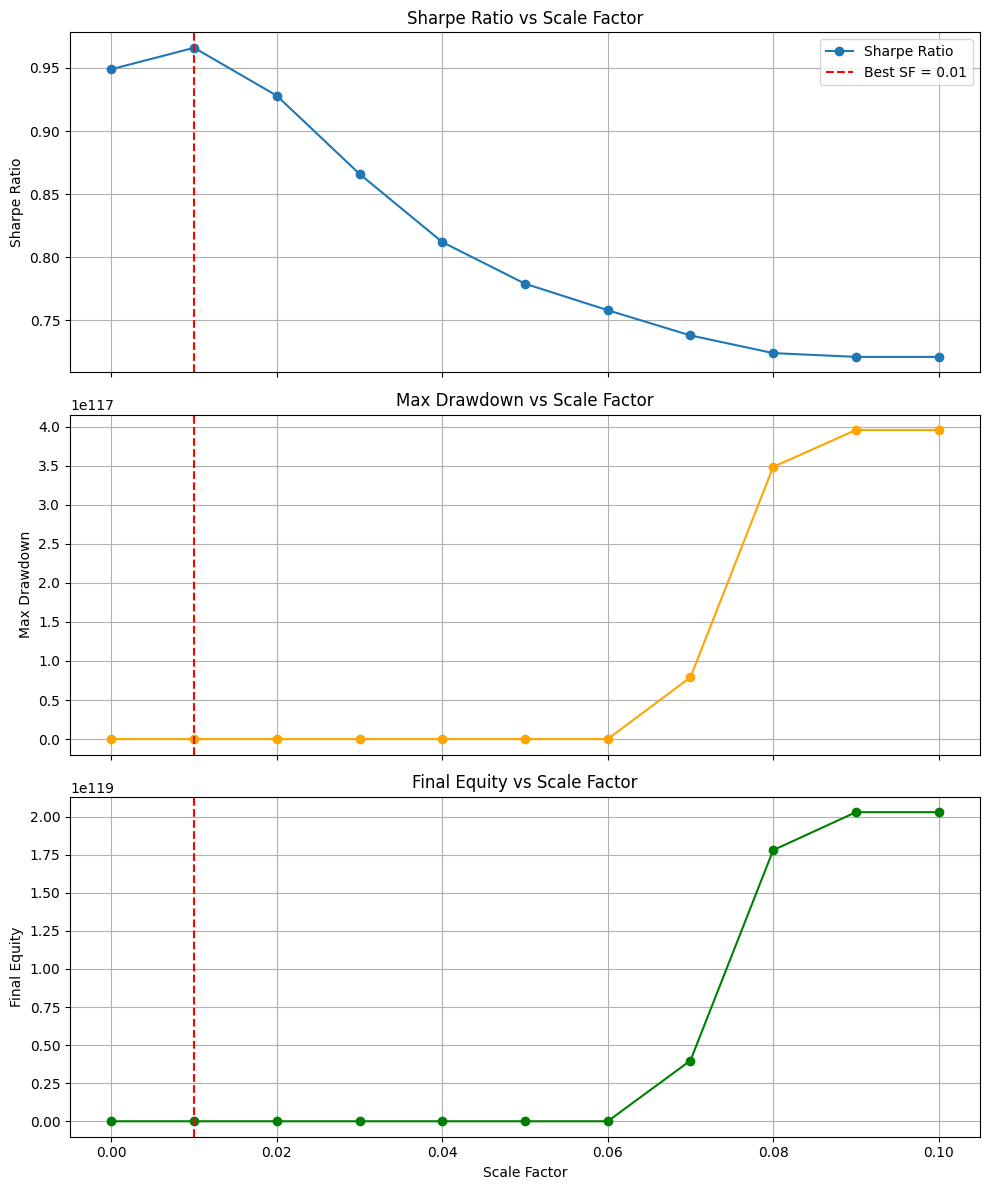

In [ ]:
import matplotlib.pyplot as plt

def plot_optimization_results(results_df, best_sf):
    """
    Plot Sharpe, Drawdown, and Final Equity vs Scale Factor.
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Sharpe Ratio Plot
    axes[0].plot(results_df['scale_factor'], results_df['sharpe'], marker='o', label='Sharpe Ratio')
    axes[0].axvline(best_sf, color='red', linestyle='--', label=f'Best SF = {best_sf:.2f}')
    axes[0].set_ylabel('Sharpe Ratio')
    axes[0].set_title('Sharpe Ratio vs Scale Factor')
    axes[0].legend()
    axes[0].grid(True)

    # Drawdown Plot
    axes[1].plot(results_df['scale_factor'], results_df['max_drawdown'], marker='o', color='orange')
    axes[1].axvline(best_sf, color='red', linestyle='--')
    axes[1].set_ylabel('Max Drawdown')
    axes[1].set_title('Max Drawdown vs Scale Factor')
    axes[1].grid(True)

    # Final Equity Plot
    axes[2].plot(results_df['scale_factor'], results_df['final_equity'], marker='o', color='green')
    axes[2].axvline(best_sf, color='red', linestyle='--')
    axes[2].set_ylabel('Final Equity')
    axes[2].set_xlabel('Scale Factor')
    axes[2].set_title('Final Equity vs Scale Factor')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


# Now plot the results
plot_optimization_results(results_df, best_sf)


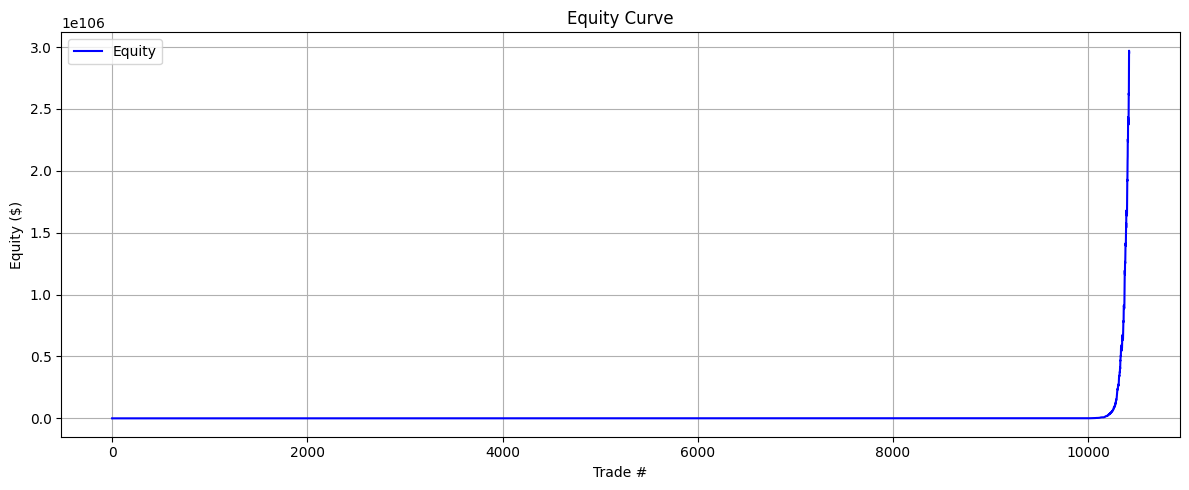

In [ ]:
def plot_equity_curve(signals_df, title='Equity Curve'):
    plt.figure(figsize=(12, 5))
    plt.plot(signals_df['equity'], label='Equity', color='blue')
    plt.title(title)
    plt.xlabel('Trade #')
    plt.ylabel('Equity ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_equity_curve(backtest_dynamic)

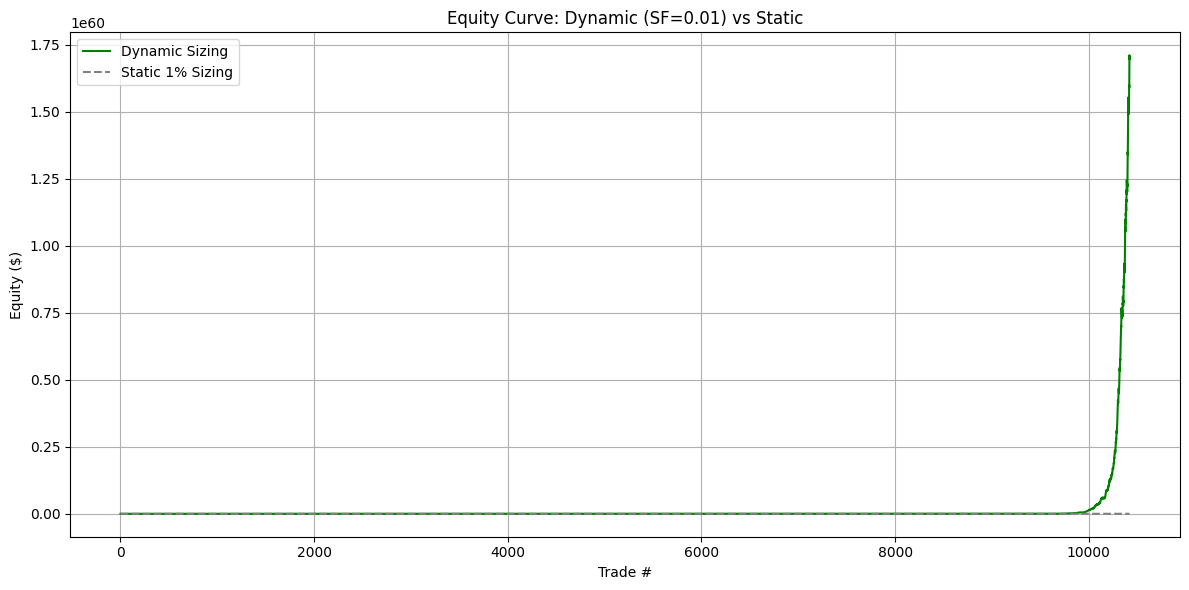

(      direction   time structure_type        signal_type  \
 0         short      3     Bearish OB   Bearish OB Entry   
 1         short      4    Bearish FVG  Bearish FVG Entry   
 2         short      7    Bearish FVG  Bearish FVG Entry   
 3         short      8    Bearish FVG  Bearish FVG Entry   
 4         short      9    Bearish FVG  Bearish FVG Entry   
 ...         ...    ...            ...                ...   
 10417     short  10413     Bearish OB   Bearish OB Entry   
 10418      long  10413            BOS           BOS Long   
 10419     short  10414    Bearish FVG  Bearish FVG Entry   
 10420     short  10415    Bearish FVG  Bearish FVG Entry   
 10421      long  10415     Bullish OB   Bullish OB Entry   
 
                                               confluence  entry_price  \
 0      Bearish OB+Bearish OB+Bearish OB+Bearish OB+Be...       3.1688   
 1      Bearish FVG+Bearish OB+Bearish OB+Bearish OB+B...       3.0896   
 2      Bearish FVG+Bearish OB+Bullish OB+Bu

In [ ]:
def compare_equity_curves(signal_df, best_sf, capital=100_000):
    # Dynamic risk
    dynamic_df = assign_dynamic_risk(signal_df, scale_factor=best_sf)
    dynamic_df = apply_position_sizing_to_backtest(dynamic_df, capital=capital)

    # Static 1% risk
    static_df = signal_df.copy()
    static_df['risk_pct'] = 0.01
    static_df = apply_position_sizing_to_backtest(static_df, capital=capital)

    # Plot both
    plt.figure(figsize=(12, 6))
    plt.plot(dynamic_df['equity'], label='Dynamic Sizing', color='green')
    plt.plot(static_df['equity'], label='Static 1% Sizing', color='gray', linestyle='--')
    plt.title(f'Equity Curve: Dynamic (SF={best_sf:.2f}) vs Static')
    plt.xlabel('Trade #')
    plt.ylabel('Equity ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dynamic_df, static_df

compare_equity_curves(backtest_dynamic, best_sf, capital=10_000)

In [ ]:
results_df.to_csv("scale_factor_optimization_results.csv", index=False)
print("🔽 Saved to: scale_factor_optimization_results.csv")

🔽 Saved to: scale_factor_optimization_results.csv


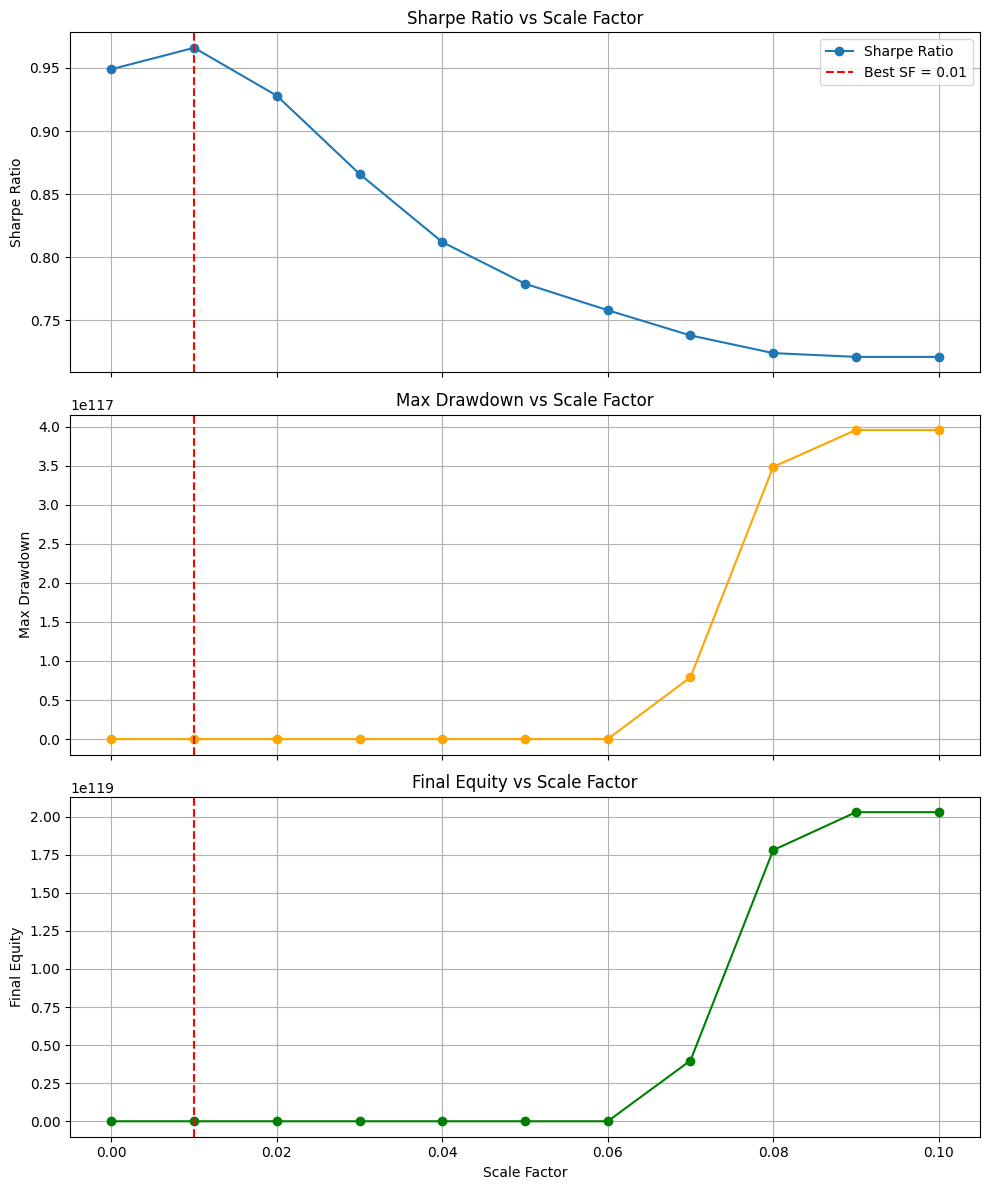

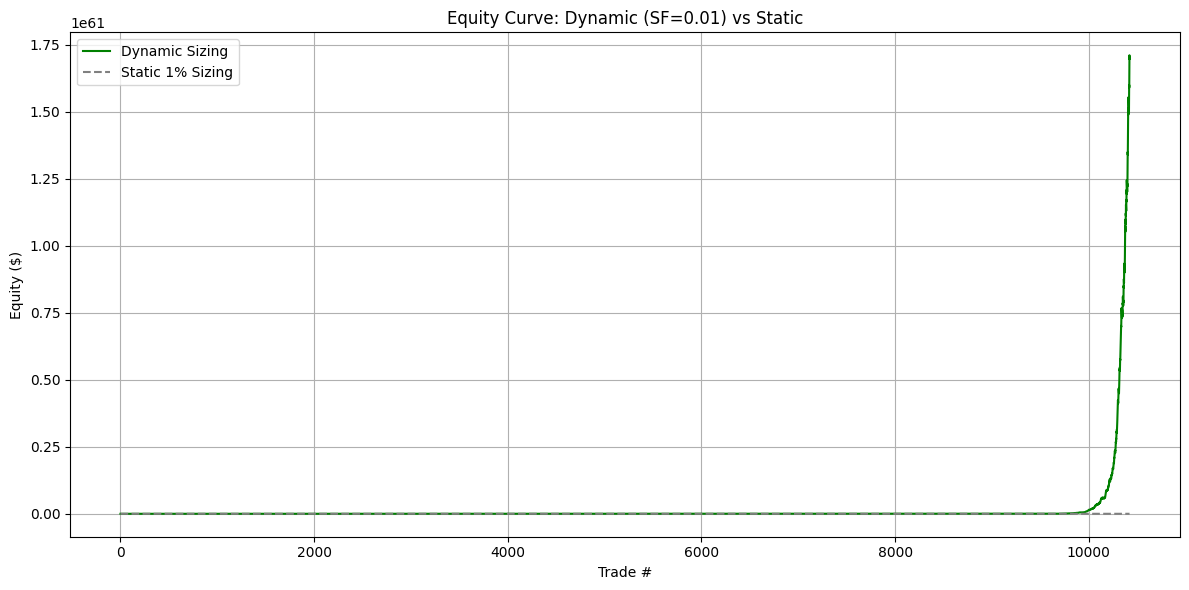

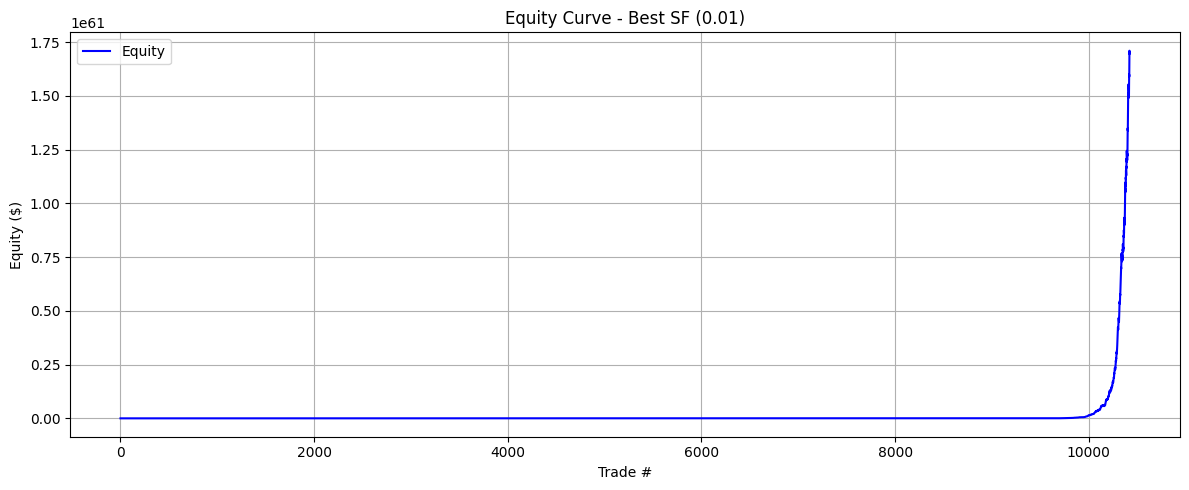

In [ ]:
# 1. Optimize
# results_df, best_sf = optimize_scale_factor(ob_fvg_signals_df)

# 2. Plot optimization metrics
plot_optimization_results(results_df, best_sf)

# 3. Compare equity curves
dynamic_df, static_df = compare_equity_curves(backtest_dynamic, best_sf)

# 4. Plot best equity
plot_equity_curve(dynamic_df, title=f'Equity Curve - Best SF ({best_sf:.2f})')

# 5. Save result
results_df.to_csv("scale_factor_optimization_results.csv", index=False)


### Metrics

In [ ]:
def compute_backtest_metrics(signal_df, risk_free_rate=0.0):
    """
    Compute performance metrics from signal DataFrame.

    Args:
        signal_df (pd.DataFrame): Must contain 'rr' and 'outcome' columns
        risk_free_rate (float): Annualized risk-free rate, default 0 for Sharpe Ratio

    Returns:
        dict: Backtest summary statistics
    """
    import numpy as np

    df = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    r = df['rr'].values
    n = len(r)

    wins = df[df['rr'] > 0]
    losses = df[df['rr'] < 0]
    win_rate = len(wins) / n if n > 0 else 0
    loss_rate = len(losses) / n if n > 0 else 0

    avg_r = np.mean(r) if n > 0 else 0
    total_r = np.sum(r)
    std_r = np.std(r) if n > 1 else 0
    sharpe = (avg_r - risk_free_rate) / std_r if std_r > 0 else 0

    gross_profit = wins['rr'].sum()
    gross_loss = abs(losses['rr'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

    expectancy = avg_r
    if loss_rate > 0 and len(losses) > 0:
        avg_loss = abs(losses['rr'].mean())
        expectancy = (wins['rr'].mean() * win_rate) - (avg_loss * loss_rate)

    # Max drawdown in R
    cum_r = np.cumsum(r)
    peak = np.maximum.accumulate(cum_r)
    drawdown = peak - cum_r
    max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

    return {
        'Win Rate (%)': round(win_rate * 100, 2),
        'Loss Rate (%)': round(loss_rate * 100, 2),
        'Average R': round(avg_r, 3),
        'Total R': round(total_r, 2),
        'Sharpe Ratio': round(sharpe, 3),
        'Profit Factor': round(profit_factor, 2),
        'Expectancy (R)': round(expectancy, 3),
        'Max Drawdown (R)': round(max_drawdown, 2),
        'Number of Trades': int(n)
    }


In [ ]:
results = compute_backtest_metrics(backtest_dynamic, risk_free_rate=0)
for k, v in results.items():
    print(f"{k}: {v}")


Win Rate (%): 49.1
Loss Rate (%): 50.9
Average R: 0.473
Total R: 4930
Sharpe Ratio: 0.315
Profit Factor: 1.93
Expectancy (R): 0.473
Max Drawdown (R): 16
Number of Trades: 10421


In [ ]:
def compute_advanced_metrics(equity_series, capital=100_000, freq='daily'):
    """
    Compute advanced metrics: Sortino, MAR, Max Drawdown, CAGR, etc.

    Args:
        equity_series (pd.Series): Equity curve
        capital (float): Starting capital
        freq (str): Frequency of trades ('daily', 'weekly')

    Returns:
        dict: metrics
    """
    returns = equity_series.pct_change().dropna()
    downside_returns = returns[returns < 0]
    trading_days = {'daily': 252, 'weekly': 52}[freq]

    avg_return = returns.mean()
    std_dev = returns.std()
    downside_std = downside_returns.std()

    sortino = (avg_return * trading_days) / (downside_std * np.sqrt(trading_days)) if downside_std > 0 else np.nan
    sharpe = (avg_return * trading_days) / (std_dev * np.sqrt(trading_days)) if std_dev > 0 else np.nan

    cum_return = equity_series.iloc[-1] / capital
    n_years = len(equity_series) / trading_days
    cagr = cum_return**(1/n_years) - 1 if n_years > 0 else np.nan

    rolling_max = equity_series.cummax()
    drawdown = (rolling_max - equity_series)
    max_drawdown = drawdown.max()
    mar = cagr / max_drawdown if max_drawdown > 0 else np.nan

    return {
        'Sharpe Ratio': round(sharpe, 3),
        'Sortino Ratio': round(sortino, 3),
        'CAGR': round(cagr * 100, 2),
        'Max Drawdown ($)': round(max_drawdown, 2),
        'MAR Ratio': round(mar, 3)
    }


compute_advanced_metrics(dynamic_df['equity'], capital=10_000)

{'Sharpe Ratio': np.float64(9.098),
 'Sortino Ratio': np.float64(104.922),
 'CAGR': np.float64(2319.86),
 'Max Drawdown ($)': 5.7426009390711965e+59,
 'MAR Ratio': np.float64(0.0)}

Sharpe Ratio: 9.098
Sortino Ratio: 104.922
CAGR: 2319.86
Max Drawdown ($): 5.7426009390711965e+59
MAR Ratio: 0.0


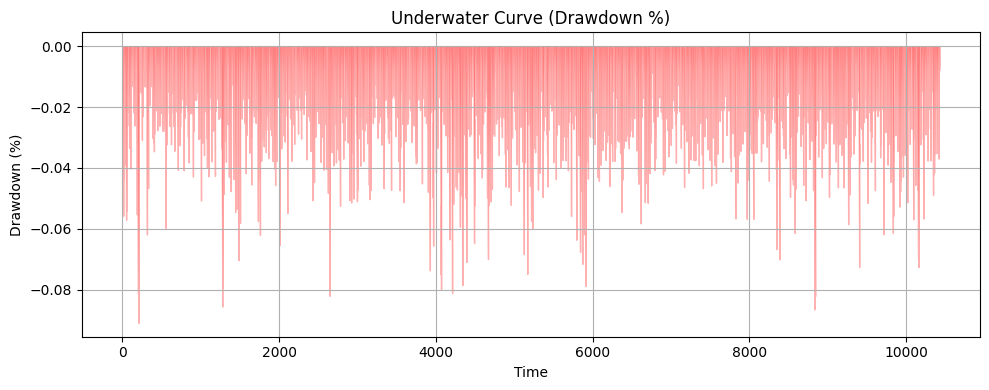

In [ ]:
def plot_underwater_curve(equity_series):
    rolling_max = equity_series.cummax()
    drawdown_pct = (equity_series - rolling_max) / rolling_max

    plt.figure(figsize=(10, 4))
    plt.fill_between(drawdown_pct.index, drawdown_pct.values, color='red', alpha=0.3)
    plt.title("Underwater Curve (Drawdown %)")
    plt.ylabel("Drawdown (%)")
    plt.xlabel("Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


metrics = compute_advanced_metrics(dynamic_df['equity'], capital=10_000)
for k, v in metrics.items():
    print(f"{k}: {v}")

plot_underwater_curve(dynamic_df['equity'])

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
import plotly.graph_objects as go

def plot_signals_on_chart(df, signal_df, show_tp2=True):
    """
    Plot price chart with signal entries, SL, TP1, and TP2 levels.

    Args:
        df (pd.DataFrame): OHLCV data with datetime index
        signal_df (pd.DataFrame): Combined signal table with entry, SL, TP1, TP2
        show_tp2 (bool): Whether to plot TP2 lines
    """
    fig = go.Figure()

    # --- Price Candles ---
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'], high=df['high'],
        low=df['low'], close=df['close'],
        name='Price'
    ))

    # --- Signal Plots ---
    for _, row in signal_df.iterrows():
        time = row['time']
        entry = row['entry_price']
        sl = row['sl_price']
        tp1 = row['tp1_price']
        tp2 = row.get('tp2_price', None)
        direction = row['direction']
        label = row['signal_type']
        color = 'green' if direction == 'long' else 'red'

        # Entry marker
        fig.add_trace(go.Scatter(
            x=[time], y=[entry],
            mode='markers+text',
            marker=dict(color=color, size=10, symbol='diamond'),
            name=f"{label} Entry",
            text=[label],
            textposition='top center'
        ))

        # SL line
        fig.add_shape(
            type='line',
            x0=time, x1=df.index[-1],
            y0=sl, y1=sl,
            line=dict(color='black', width=1, dash='dot'),
            name='SL'
        )
        fig.add_annotation(
            x=time,
            y=sl,
            text="SL",
            showarrow=False,
            font=dict(color='black'),
            yshift=-10
        )

        # TP1 line
        fig.add_shape(
            type='line',
            x0=time, x1=df.index[-1],
            y0=tp1, y1=tp1,
            line=dict(color='blue', width=1, dash='dash'),
            name='TP1'
        )
        fig.add_annotation(
            x=time,
            y=tp1,
            text="TP1",
            showarrow=False,
            font=dict(color='blue'),
            yshift=10
        )

        # TP2 line
        if show_tp2 and pd.notna(tp2):
            fig.add_shape(
                type='line',
                x0=time, x1=df.index[-1],
                y0=tp2, y1=tp2,
                line=dict(color='purple', width=1, dash='dot'),
                name='TP2'
            )
            fig.add_annotation(
                x=time,
                y=tp2,
                text="TP2",
                showarrow=False,
                font=dict(color='purple'),
                yshift=10
            )

    # --- Final Layout ---
    fig.update_layout(
        title='Trade Signals with SL / TP1 / TP2',
        xaxis_title='Time',
        yaxis_title='Price',
        template='plotly_white',
        height=800
    )
    fig.show()

# Plot all entries + SL + TP1 + TP2
# plot_signals_on_chart(ohlcv, combined_signals, show_tp2=True)

In [ ]:
import plotly.graph_objects as go

def plot_backtest_dashboard(df, signal_df, metrics, title="Backtest Dashboard"):
    """
    Plot an interactive dashboard showing equity curve and performance metrics.

    Args:
        df (pd.DataFrame): OHLCV dataframe (not used here directly but for potential overlay)
        signal_df (pd.DataFrame): Signal DataFrame with 'rr' and 'time'
        metrics (dict): Dictionary from compute_backtest_metrics()
        title (str): Plot title
    """
    # Compute cumulative equity in R units
    closed_trades = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    closed_trades = closed_trades.sort_values('time')
    closed_trades['cumulative_rr'] = np.cumsum(closed_trades['rr'].values)

    # Plot equity curve
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=closed_trades['cumulative_rr'],
        mode='lines+markers',
        name='Equity Curve (R)',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6)
    ))

    # Annotate metrics in top-left corner
    metric_text = "<br>".join([f"{k}: {v}" for k, v in metrics.items()])
    fig.add_annotation(
        text=metric_text,
        xref="paper", yref="paper",
        x=0.01, y=0.99,
        showarrow=False,
        align="left",
        font=dict(size=12),
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.95
    )

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Cumulative R",
        template="plotly_white",
        height=600
    )

    fig.show()



In [ ]:
# # Run metrics calculation
# metrics = compute_backtest_metrics(backtest_results)

# # Plot the dashboard
# plot_backtest_dashboard(ohlcv, backtest_results, metrics, title="Strategy Performance Overview")


In [ ]:
def plot_backtest_dashboard_with_drawdown(df, signal_df, metrics, title="Backtest Dashboard with Trades & Drawdown"):
    """
    Plot dashboard with:
        - Equity curve
        - Maximum drawdown line
        - Metrics annotation
        - Trade markers on price chart
    """
    import plotly.graph_objects as go
    import numpy as np

    # Compute equity curve
    closed_trades = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    closed_trades = closed_trades.sort_values('time')
    closed_trades['cumulative_rr'] = np.cumsum(closed_trades['rr'].values)

    # Compute drawdown curve
    cum_r = closed_trades['cumulative_rr'].values
    peak = np.maximum.accumulate(cum_r)
    drawdown = peak - cum_r

    # Initialize figure
    fig = go.Figure()

    # Equity Curve
    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=closed_trades['cumulative_rr'],
        mode='lines+markers',
        name='Equity Curve (R)',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6)
    ))

    # Drawdown Line
    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=drawdown,
        mode='lines',
        name='Drawdown (R)',
        line=dict(color='firebrick', width=1, dash='dot'),
        yaxis='y2'
    ))

    # Annotate metrics
    metric_text = "<br>".join([f"{k}: {v}" for k, v in metrics.items()])
    fig.add_annotation(
        text=metric_text,
        xref="paper", yref="paper",
        x=0.01, y=0.99,
        showarrow=False,
        align="left",
        font=dict(size=12),
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.95
    )

    # Layout with dual Y-axes
    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis=dict(title="Cumulative R", side='left'),
        yaxis2=dict(title="Drawdown R", overlaying='y', side='right', showgrid=False),
        template="plotly_white",
        height=700
    )

    fig.show()


# metrics = compute_backtest_metrics(backtest_results)
# plot_backtest_dashboard_with_drawdown(ohlcv, backtest_results, metrics)

In [ ]:
stop